# Personalized Medicine: Redefining Cancer Treatment
- Hola amigos, this notebook covers my code for the **Personalized Medicine: Redefining Cancer Treatment** challenge, which can be found [here](https://www.kaggle.com/c/msk-redefining-cancer-treatment).
- This work is largely inspired by the **Applied AI Course**, and I would like to say a special thanks to the entire team of Applied AI.

# Installing & Importing Packages

In [122]:
!pip install prettytable

In [18]:
import re
import time
import nltk
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from datetime import datetime
from collections import Counter, defaultdict
from scipy.sparse import hstack
from nltk.corpus import stopwords
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics._classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("ignore");
nltk.download('stopwords');

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rache\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# To find the running time of the entire kernel
globalstart = datetime.now()

# 1. Business Problem
## 1.1. Description

- **Data**: https://www.kaggle.com/c/msk-redefining-cancer-treatment/
- **Source**: Memorial Sloan Kettering Cancer Center (MSKCC)
- **Context Source**: https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462
- **Problem statement**: Classify the given genetic variations/mutations based on evidence from text-based clinical literature.

## 1.2. Source/Useful Links
-  Some articles and reference blogs about the problem statement

1. https://www.forbes.com/sites/matthewherper/2017/06/03/a-new-cancer-drug-helped-almost-everyone-who-took-it-almost-heres-what-it-teaches-us/#2a44ee2f6b25
2. https://www.youtube.com/watch?v=UwbuW7oK8rk 
3. https://www.youtube.com/watch?v=qxXRKVompI8

## 1.3. Real-world/Business objectives and constraints.
- No low-latency requirement.
- Interpretability is important.
- Errors can be very costly.
- Probability of a data-point belonging to each class is needed.

# 2. Machine Learning Problem Formulation
## 2.1. Data
### 2.1.1. Data Overview

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID
- Data file's information:
    - training_variants (ID , Gene, Variations, Class)
    - training_text (ID, Text)
    
### 2.1.2. Example Data Point
**training_variants**<br>
...................<br>
ID,Gene,Variation,Class<br>
0,FAM58A,Truncating Mutations,1 <br>
1,CBL,W802*,2 <br>
2,CBL,Q249E,2 <br>

<hr>

**training_text**<br>
...................<br>
ID,Text <br>
0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK10 silencing in increasing c-Raf and in conferring tamoxifen resistance to breast cancer cells. CDK10/cyclin M phosphorylates ETS2 in vitro, and in cells it positively controls ETS2 degradation by the proteasome. ETS2 protein levels are increased in cells derived from a STAR patient, and this increase is attributable to decreased cyclin M levels. Altogether, our results reveal an additional regulatory mechanism for ETS2, which plays key roles in cancer and development. They also shed light on the molecular mechanisms underlying STAR syndrome.Cyclin-dependent kinases (CDKs) play a pivotal role in the control of a number of fundamental cellular processes (1). The human genome contains 21 genes encoding proteins that can be considered as members of the CDK family owing to their sequence similarity with bona fide CDKs, those known to be activated by cyclins (2). Although discovered almost 20 y ago (3, 4), CDK10 remains one of the two CDKs without an identified cyclin partner. This knowledge gap has largely impeded the exploration of its biological functions. CDK10 can act as a positive cell cycle regulator in some cells (5, 6) or as a tumor suppressor in others (7, 8). CDK10 interacts with the ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2) transcription factor and inhibits its transcriptional activity through an unknown mechanism (9). CDK10 knockdown derepresses ETS2, which increases the expression of the c-Raf protein kinase, activates the MAPK pathway, and induces resistance of MCF7 cells to tamoxifen (6).


## 2.2. Mapping the real-world problem to an ML problem
### 2.2.1. Type of Machine Learning Problem
- There are nine different classes a genetic mutation can be classified into => Multi class classification problem

### 2.2.2. Performance Metric
- **Source**: https://www.kaggle.com/c/msk-redefining-cancer-treatment#evaluation
- **Metric(s)**: 
    - Multi class log-loss 
    - Confusion matrix 
    
### 2.2.3. Machine Learing Objectives and Constraints
- **Objective**: Predict the probability of each data-point belonging to each of the nine classes.
- **Constraints**:
    - Interpretability
    - Class probabilities are needed.
    - Penalize the errors in class probabilites => Metric is Log-loss.
    - No Latency constraints.
    
## 2.3. Train, CV and Test Datasets
- Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively


# 3. Exploratory Data Analysis
## 3.1. Reading Data
### 3.1.1. Reading Gene and Variation Data

In [20]:
data = pd.read_csv('training_variants')
print('Number of data points:', data.shape[0])
print('Number of features:', data.shape[1])
print('Features:', data.columns.values)
data.head()

Number of data points: 3321
Number of features: 4
Features: ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


- 'training_variants' is a comma separated file containing the description of the genetic mutations used for training.
- Fields are:
    - **ID**: the id of the row used to link the mutation to the clinical evidence
    - **Gene**: the gene where this genetic mutation is located
    - **Variation**: the aminoacid change for this mutations 
    - **Class**: 1-9 the class this genetic mutation has been classified on
    
### 3.1.2. Reading Text Data

In [21]:
# Note the seprator in this file
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


### 3.1.3. Preprocessing of text

In [22]:
# Loading stop words from nltk library
stop_words = set(stopwords.words('english'))

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # Replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # Replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # Converting all the chars into lower-case
        total_text = total_text.lower()
        
        for word in total_text.split():
        # If the word is not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [27]:
# Text processing stage.
start_time = time.process_time()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("There is no text description for id:", index)
print('Time took for preprocessing the text:', time.process_time() - start_time, "seconds")

There is no text description for id: 1109
There is no text description for id: 1277
There is no text description for id: 1407
There is no text description for id: 1639
There is no text description for id: 2755
Time took for preprocessing the text: 20.25 seconds


In [28]:
# Merging both gene_variations and text data based on ID
result = pd.merge(data, data_text, on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [29]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [30]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] + ' ' + result['Variation']
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


### 3.1.4. Test, Train and Cross Validation Split
#### 3.1.4.1. Splitting data into train, test and cross validation (64:20:16)

In [31]:
#  We split the data into train, test and cross validation data sets, 
# preserving the ratio of class distribution in the original data set 

y_true = result['Class'].values
result.Gene = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# Split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# Split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [32]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross-validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross-validation data: 532


#### 3.1.4.2. Distribution of y_i's in Train, Test and Cross Validation datasets

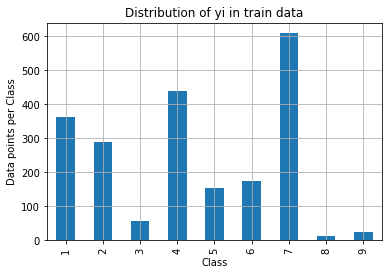

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


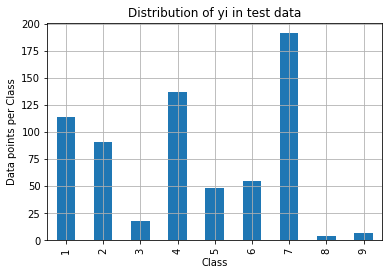

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


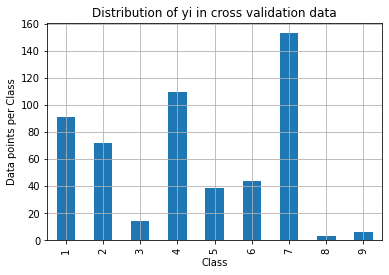

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [33]:
# It returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): The minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', 
      np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')
    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


## 3.2 Prediction using a 'Random' Model
- In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1.

In [34]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    C = confusion_matrix(test_y, predict_y)
    
    # Divide each element of the confusion matrix with the sum of elements in that column
    A = (((C.T)/(C.sum(axis=1))).T)
    
    # Divide each element of the confusion matrix with the sum of elements in that row
    B =(C/C.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9]
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.480666760092463
Log loss on Test Data using Random Model 2.420763754796268
-------------------- Confusion matrix --------------------


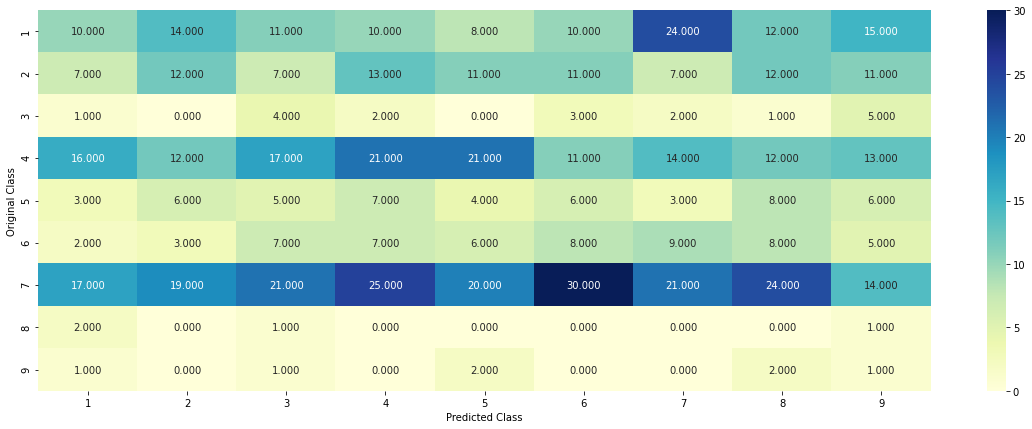

-------------------- Precision matrix (Columm Sum=1) --------------------


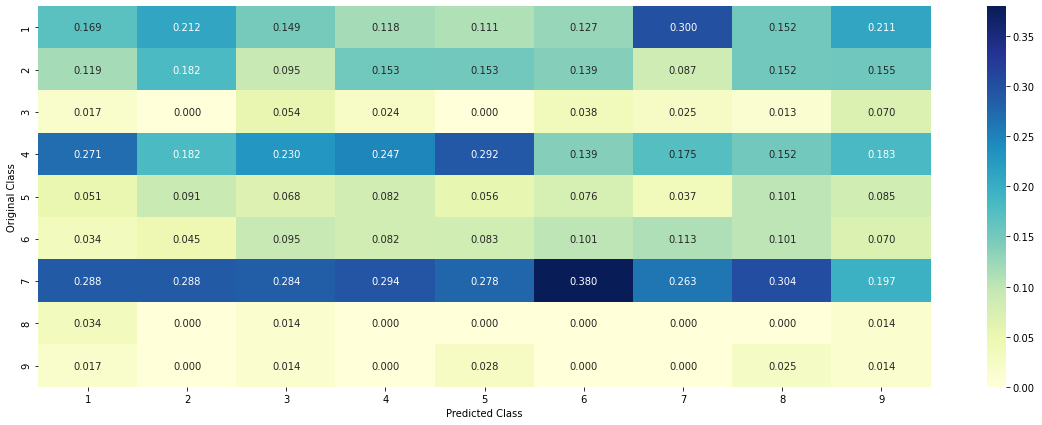

-------------------- Recall matrix (Row sum=1) --------------------


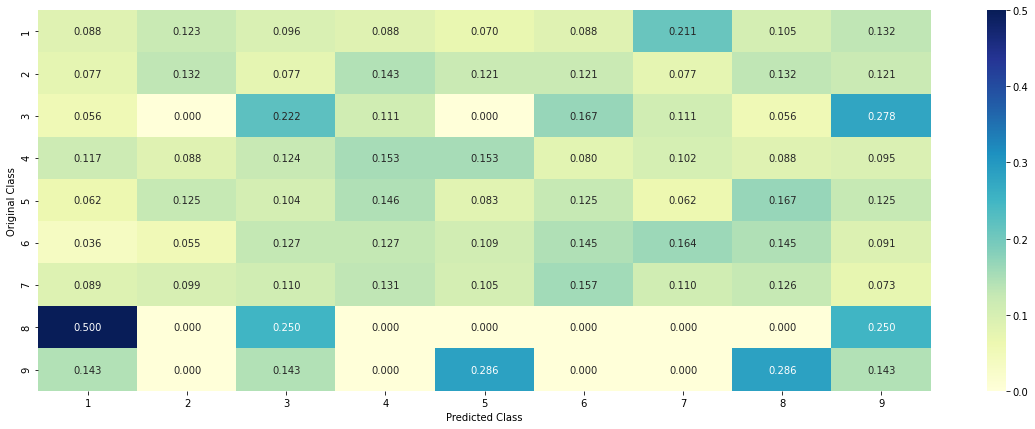

In [35]:
# We need to generate 9 numbers and the sum of numbers should be 1
# One solution is to generate 9 numbers and divide each of the numbers by their sum
# Ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# We create an output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model", log_loss(y_cv,cv_predicted_y, eps=1e-15))

# We create an output array that has exactly same size as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model", log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y = np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

## 3.3 Univariate Analysis

In [36]:
# Code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurences of given feature in train data dataframe.
# Build a vector (1*9), the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# For a value of feature in df:
# If it is in train data:
# We add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# If it is not there in train:
# We add [1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene Variation Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # Denominator will contain the number of times that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # We are adding the gene/variation to the dict as key and vec as value
        gv_dict[i] = vec
    return gv_dict

# Get Gene Variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # For every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # If not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in gv_dict.keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

- When we caculate the probability of a feature belonging to any particular class, we apply Laplace Smoothing
- (numerator + 10\*alpha) / (denominator + 90\*alpha)

### 3.2.1 Univariate Analysis on Gene Feature

- **Q1**- Gene, What type of feature it is ?
- **A1**- Gene is a categorical variable
- **Q2**- How many categories are there and How they are distributed?

In [37]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])

# Top 10 most frequent genes
print(unique_genes.head(10))

print("There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows")

Number of Unique Genes : 225
BRCA1     160
EGFR       87
PTEN       85
TP53       85
BRCA2      78
KIT        62
BRAF       57
ERBB2      46
ALK        42
PIK3CA     37
Name: Gene, dtype: int64
There are 225 different categories of genes in the train data, and they are distibuted as follows


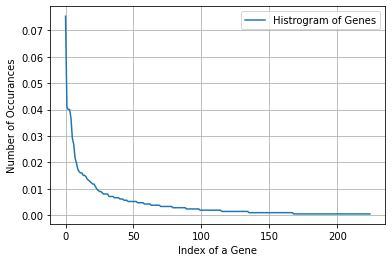

In [38]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

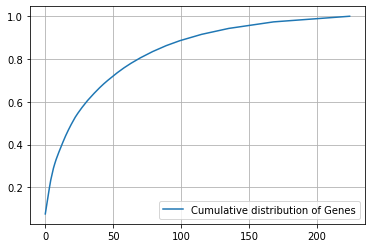

In [39]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

- **Q3**- How to featurize this Gene feature?
- **A3**- There are two ways we can featurize this variable
    - Check out this video: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/
    - One hot Encoding
    - Response coding

- We will choose the appropriate featurization based on the ML model we use. For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests.

In [40]:
# Response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# Train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# Test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# Cross-Validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [41]:
# One-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [42]:
print(train_df['Gene'].head())

2929    NFE2L2
2029    MAP2K1
1088      EZH2
1695      PMS2
1136       MET
Name: Gene, dtype: object


In [43]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 224)


- **Q4**- How good is this gene feature  in predicting y_i?
- There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one-hot encoded) to predict y_i.

For values of alpha: 1e-05 The log loss is: 1.2431484330865212
For values of alpha: 0.0001 The log loss is: 1.2302368395397294
For values of alpha: 0.001 The log loss is: 1.2766681043955557
For values of alpha: 0.01 The log loss is: 1.3852257933631447
For values of alpha: 0.1 The log loss is: 1.4643382108610061
For values of alpha: 1 The log loss is: 1.4946613801626754


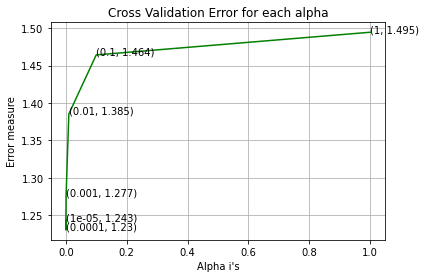

For values of best alpha: 0.0001 The train log loss is: 0.9613134242997207
For values of best alpha: 0.0001 The cross validation log loss is: 1.2302368395397294
For values of best alpha: 0.0001 The test log loss is: 1.1975756362712553


In [44]:
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha:', i, "The log loss is:", log_loss(y_cv, predict_y, labels = clf.classes_, eps = 1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c = 'g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha:', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha:', alpha[best_alpha], "The cross validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha:', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

- **Q5**- Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?
- **A5**- Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error.

In [45]:
print("Q6. How many data points in Test and CV datasets are covered by the", unique_genes.shape[0], "genes in train dataset?")

test_coverage = test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage = cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('In test data', test_coverage, 'out of', test_df.shape[0], ":", (test_coverage/test_df.shape[0])*100)
print('In cross-validation data', cv_coverage, 'out of', cv_df.shape[0], ":" , (cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the 225 genes in train dataset?
In test data 634 out of 665 : 95.33834586466166
In cross-validation data 512 out of 532 : 96.2406015037594


### 3.2.2 Univariate Analysis on Variation Feature
- **Q7**- Variation, What type of feature is it?
- **A7**- Variation is a categorical variable
- **Q8**- How many categories are there?

In [46]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])

# Top 10 most frequent variations
print(unique_variations.head(10))

print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows")

Number of Unique Variations : 1919
Truncating_Mutations    65
Deletion                54
Amplification           46
Fusions                 21
G12V                     4
Overexpression           3
Q61H                     3
E17K                     3
Q61L                     3
R170W                    2
Name: Variation, dtype: int64
Ans: There are 1919 different categories of variations in the train data, and they are distibuted as follows


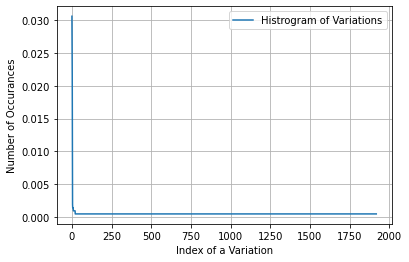

In [47]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.03060264 0.05602637 0.07768362 ... 0.99905838 0.99952919 1.        ]


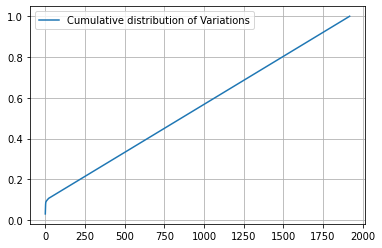

In [48]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

- **Q9**- How to featurize this Variation feature?
- **A9**- There are two ways we can featurize this variable
    - Check out this video: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/
    - One hot Encoding
    - Response coding
- We will be using both these methods to featurize the Variation Feature

In [49]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [50]:
# One-hot encoding of variation feature
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

- **Q10**- How good is this Variation feature  in predicting y_i?
- **A10**- Let's build a model just like the earlier!

For values of alpha =  1e-05 The log loss is: 1.715036272941465
For values of alpha =  0.0001 The log loss is: 1.7054773760466917
For values of alpha =  0.001 The log loss is: 1.7047347126054482
For values of alpha =  0.01 The log loss is: 1.716700953386265
For values of alpha =  0.1 The log loss is: 1.7234565613593755
For values of alpha =  1 The log loss is: 1.7272513318811729


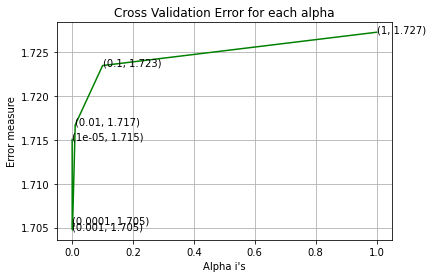

For values of best alpha =  0.001 The train log loss is: 1.0783311383250265
For values of best alpha =  0.001 The cross validation log loss is: 1.7047347126054482
For values of best alpha =  0.001 The test log loss is: 1.7289926263867483


In [51]:
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array = []

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

- **Q11**- Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?
- **A11**- Not sure! But let's be very sure using the below analysis.

In [52]:
print("Q12. How many data points are covered by total", unique_variations.shape[0], "genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total 1919 genes in test and cross validation data sets?
In test data 60 out of 665 : 9.022556390977442
In cross validation data 54 out of  532 : 10.150375939849624


### 3.2.3 Univariate Analysis on Text Feature
1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [53]:
# cls_text is a data frame
# For every row in data-frame consider the 'TEXT'
# Split the words by space
# Make a dict with those words
# Increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [54]:
# https://stackoverflow.com/a/1602964
# The Data-frame passed to this function might be shuffled in terms of its indices
# And hence, we have maintained a separate`row_index' instead of using the for loop 'index' variable

def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(( (dict_list[i].get(word,0)+10) / (total_dict.get(word,0)+90) ))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [55]:
# Building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df = 3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])

# Getting all the feature names (words)
train_text_features = text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with the number of times it occured
text_fea_dict = dict(zip(list(train_text_features), train_text_fea_counts))

print("Total number of unique words in train data:", len(train_text_features))

Total number of unique words in train data: 53365


In [56]:
# dict_list = [] contains 9 dictoinaries each corresponds to a class
dict_list = []

for i in range(1,10):
    # Build a word dict based on the words in that class
    cls_text = train_df[train_df['Class']==i]
    # Append it to dict_list
    dict_list.append(extract_dictionary_paddle(cls_text))

# dict_list[i] is build on i'th  class text data
# total_dict is build on whole training text data
total_dict = extract_dictionary_paddle(train_df)

confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append( (dict_list[j][i]+10) / (total_dict[i]+90) )
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [57]:
# Response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [58]:
# https://stackoverflow.com/a/16202486
# We convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [59]:
# Don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# We use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# Don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# We use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# Don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [60]:
# https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [61]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5295, 4: 3348, 5: 3144, 6: 2889, 7: 2015, 8: 1882, 9: 1852, 12: 1456, 10: 1416, 11: 1222, 13: 997, 14: 948, 15: 810, 18: 762, 16: 755, 24: 616, 17: 569, 20: 549, 19: 549, 21: 515, 22: 463, 25: 416, 26: 408, 39: 368, 23: 356, 28: 348, 30: 346, 27: 333, 44: 310, 33: 305, 36: 288, 29: 285, 32: 275, 35: 264, 31: 246, 34: 237, 40: 219, 37: 211, 42: 208, 45: 203, 41: 201, 38: 194, 48: 190, 50: 182, 43: 173, 47: 172, 49: 161, 54: 153, 46: 153, 52: 149, 51: 147, 53: 144, 60: 143, 56: 138, 58: 136, 61: 132, 55: 129, 66: 128, 68: 117, 57: 108, 90: 107, 72: 106, 65: 105, 64: 103, 63: 100, 59: 100, 80: 96, 74: 95, 62: 94, 78: 92, 71: 91, 67: 90, 69: 84, 83: 83, 76: 78, 84: 77, 70: 76, 75: 75, 92: 73, 91: 73, 81: 73, 73: 73, 95: 71, 82: 71, 96: 70, 87: 70, 98: 68, 77: 68, 89: 66, 79: 66, 88: 65, 108: 62, 85: 62, 99: 57, 103: 56, 120: 55, 117: 55, 102: 54, 97: 54, 110: 53, 100: 52, 86: 52, 135: 50, 93: 49, 107: 48, 104: 48, 112: 47, 101: 47, 127: 45, 116: 45, 115: 45, 113: 45, 142: 44, 9

For values of alpha =  1e-05 The log loss is: 1.3479284667526852
For values of alpha =  0.0001 The log loss is: 1.251124702802403
For values of alpha =  0.001 The log loss is: 1.2637556221464687
For values of alpha =  0.01 The log loss is: 1.3465048843109504
For values of alpha =  0.1 The log loss is: 1.530665998547578
For values of alpha =  1 The log loss is: 1.6887354862595478


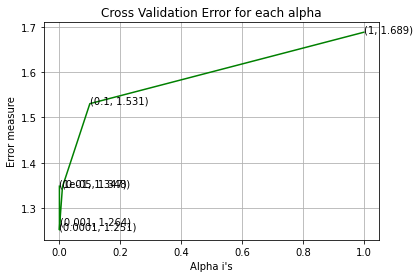

For values of best alpha =  0.0001 The train log loss is: 0.6447318143948093
For values of best alpha =  0.0001 The cross validation log loss is: 1.251124702802403
For values of best alpha =  0.0001 The test log loss is: 1.1971878331008092


In [62]:
# Train a Logistic Regression + Calibration model using text features which are one-hot encoded
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

- **Ques**- Is the Text feature stable across all the data sets (Test, Train, Cross validation)?
- **Ans**- Yes, it seems like!

In [63]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()
    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [64]:
len1, len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of words of Test data appeared in train data")
len1, len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of words of Cross Validation appeared in train data")

98.299 % of words of Test data appeared in train data
98.435 % of words of Cross Validation appeared in train data


# 4. Machine Learning Models

In [65]:
# Data preparation for ML models.
# Misc. functions for ML models

def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # For calculating log_loss, we will provide the array of probabilities belonging to each class
    print("Log loss:", log_loss(test_y, sig_clf.predict_proba(test_x)))
    # Calculating the number of data points that are misclassified
    print("Number of mis-classified points:", np.count_nonzero((pred_y-test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [66]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [67]:
# This function will be used just for naive bayes
# For the given indices, we will print the name of the features
# And we will check whether the feature is present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top", no_features, "features", word_present, "are present in query point")

<p style="font-size:24px;text-align:Center"> <b>Stacking the three types of features </b><p>

In [68]:
# Merging gene, variance and text features
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [69]:
print("One-hot encoding features:")
print("(Number of data points * Number of features) in train data =", train_x_onehotCoding.shape)
print("(Number of data points * Number of features) in test data =", test_x_onehotCoding.shape)
print("(Number of data points * Number of features) in cross-validation data =", cv_x_onehotCoding.shape)

One-hot encoding features:
(Number of data points * Number of features) in train data = (2124, 55543)
(Number of data points * Number of features) in test data = (665, 55543)
(Number of data points * Number of features) in cross-validation data = (532, 55543)


In [70]:
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [71]:
print("Response encoding features :")
print("(Number of data points * Number of features) in train data = ", train_x_responseCoding.shape)
print("(Number of data points * Number of features) in test data = ", test_x_responseCoding.shape)
print("(Number of data points * Number of features) in cross-validation data =", cv_x_responseCoding.shape)

Response encoding features :
(Number of data points * Number of features) in train data =  (2124, 27)
(Number of data points * Number of features) in test data =  (665, 27)
(Number of data points * Number of features) in cross-validation data = (532, 27)


## 4.1. Base Line Model
### 4.1.1. Naive Bayes
#### 4.1.1.1. Hyper parameter tuning

For alpha = 1e-05
Log Loss: 1.2871626254411381
For alpha = 0.0001
Log Loss: 1.2886905876792796
For alpha = 0.001
Log Loss: 1.292501406225651
For alpha = 0.1
Log Loss: 1.3000637517377245
For alpha = 1
Log Loss: 1.3037801870017338
For alpha = 10
Log Loss: 1.4186584510359108
For alpha = 100
Log Loss: 1.4225602397300743
For alpha = 1000
Log Loss: 1.382221663457039


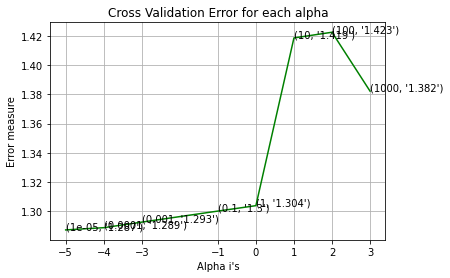

For values of best alpha =  1e-05 The train log loss is: 0.7476520349867793
For values of best alpha =  1e-05 The cross-validation log loss is: 1.2871626254411381
For values of best alpha =  1e-05 The test log loss is: 1.3424016515861381


In [72]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # To avoid rounding error while multiplying probabilites, we use log-probability estimates
    print("Log Loss:", log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
    
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### 4.1.1.2. Testing the model with best hyper paramters

Log Loss: 1.2871626254411381
Number of mis-classified points: 0.40037593984962405
-------------------- Confusion matrix --------------------


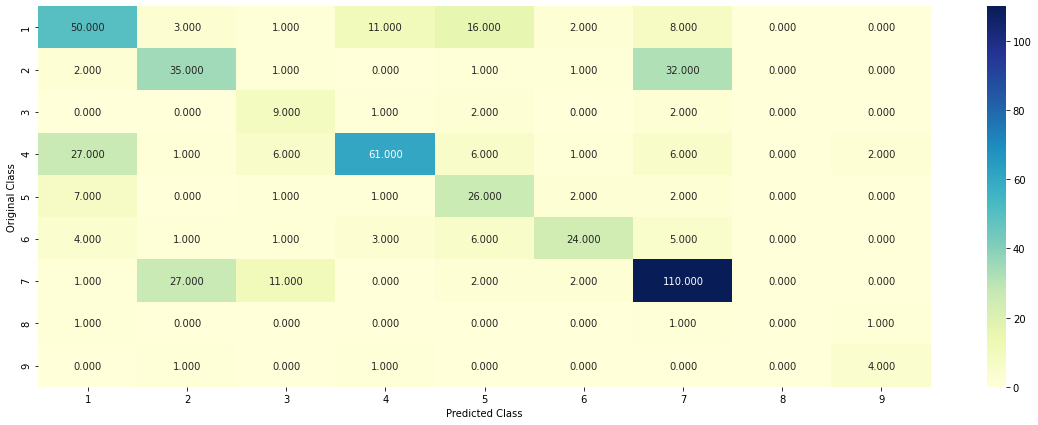

-------------------- Precision matrix (Columm Sum=1) --------------------


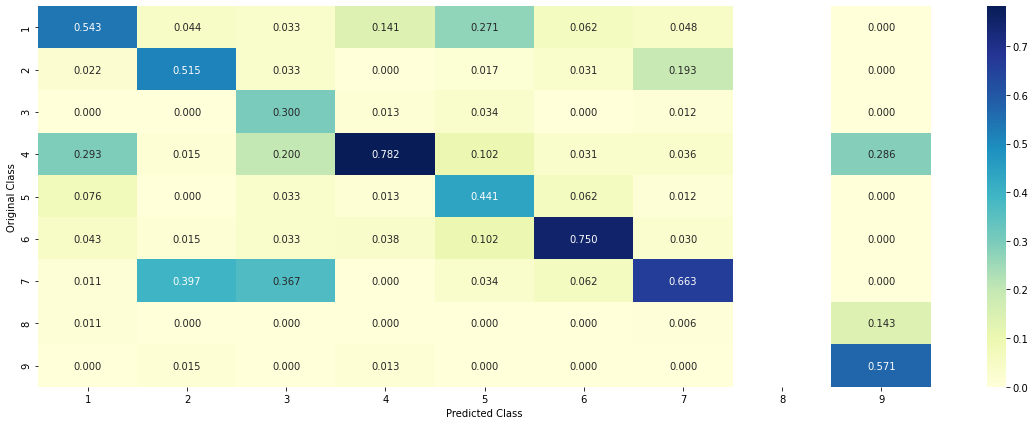

-------------------- Recall matrix (Row sum=1) --------------------


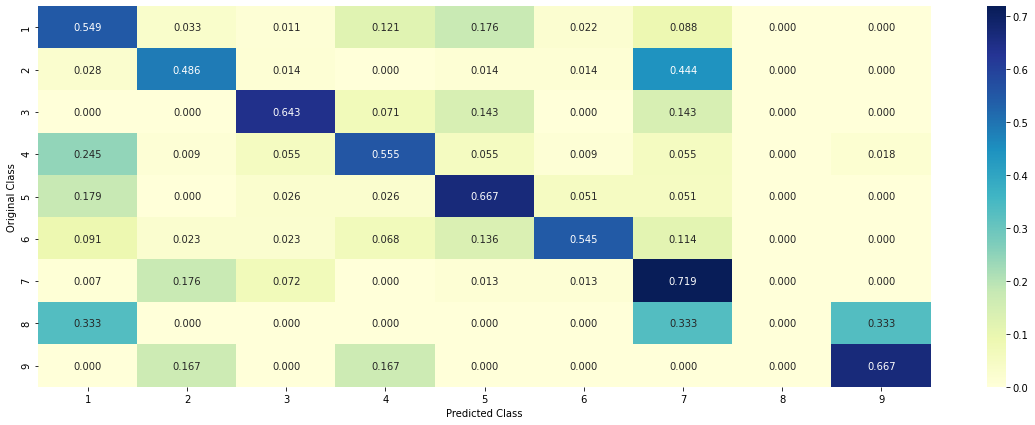

In [73]:
clf = MultinomialNB(alpha = alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)

# To avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss:", log_loss(cv_y, sig_clf_probs))
print("Number of mis-classified points:", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

#### 4.1.1.3. Feature Importance, Correctly classified point

In [74]:
test_point_index = 0
no_feature = 200
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class:", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class:", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],
    test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class: 4
Predicted Class Probabilities: [[0.0749 0.0793 0.0083 0.6789 0.0301 0.0324 0.0867 0.0055 0.0038]]
Actual Class: 1
--------------------------------------------------
Out of the top 200 features 0 are present in query point


In [75]:
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:, :no_feature]
print(clf.coef_.shape)
print(indices[0])

(9, 55543)
[    0 29514 29509 29507 29506 29504 29503 29499 29494 29492 29488 29481
 29479 29478 29477 29476 29474 29469 29468 29464 29463 29459 29456 29450
 29449 29448 29443 29442 29516 29440 29517 29520 29607 29605 29602 29601
 29600 29599 29595 29594 29591 29590 29588 29585 29583 29582 29572 29569
 29567 29565 29564 29552 29551 29548 29545 29539 29525 29523 29522 29518
 29614 29439 29432 29339 29336 29331 29329 29326 29324 29321 29319 29316
 29314 29300 29299 29295 29294 29293 29289 29288 29285 29281 29279 29276
 29274 29273 29272 29269 29265 29259 29340 29434 29344 29356 29429 29427
 29424 29423 29422 29421 29418 29417 29415 29414 29409 29408 29403 29399
 29397 29394 29391 29389 29385 29382 29381 29380 29376 29373 29372 29361
 29358 29353 29616 29617 29618 29824 29823 29822 29817 29814 29813 29810
 29808 29807 29805 29802 29797 29796 29793 29792 29791 29788 29787 29786
 29785 29783 29774 29773 29770 29767 29766 29763 29826 29762 29828 29831
 29890 29888 29879 29877 29872 29870 298

#### 4.1.1.4. Feature Importance, Incorrectly classified point

In [76]:
test_point_index = 1
no_feature = 200
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],
    test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 3
Predicted Class Probabilities: [[0.0975 0.1033 0.4768 0.1142 0.0394 0.0425 0.1141 0.0072 0.0049]]
Actual Class : 7
--------------------------------------------------
Out of the top 200 features 0 are present in query point


## 4.2. K Nearest Neighbour Classification
### 4.2.1. Hyper parameter tuning

For alpha = 5
Log Loss: 1.1250024135968408
For alpha = 11
Log Loss: 1.123483365799362
For alpha = 15
Log Loss: 1.1224483923822817
For alpha = 21
Log Loss: 1.1251587195776356
For alpha = 31
Log Loss: 1.119122373373185
For alpha = 41
Log Loss: 1.119799520477866
For alpha = 51
Log Loss: 1.1282835101164972
For alpha = 99
Log Loss: 1.1423447191771012


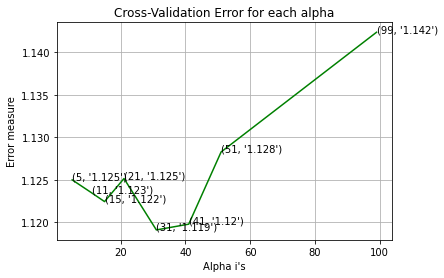

For values of best alpha = 31 The train log loss is: 0.8017019017374463
For values of best alpha = 31 The cross-validation log loss is: 1.119122373373185
For values of best alpha = 31 The test log loss is: 1.1101311202729292


In [77]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # To avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss:", log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross-Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha =', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha =', alpha[best_alpha], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha =', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 4.2.2. Testing the model with best hyper paramters

Log loss: 1.119122373373185
Number of mis-classified points: 0.40601503759398494
-------------------- Confusion matrix --------------------


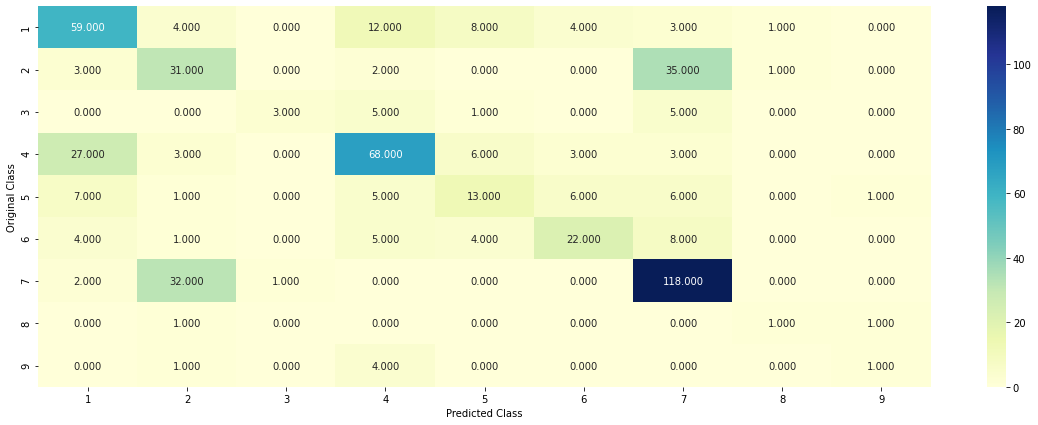

-------------------- Precision matrix (Columm Sum=1) --------------------


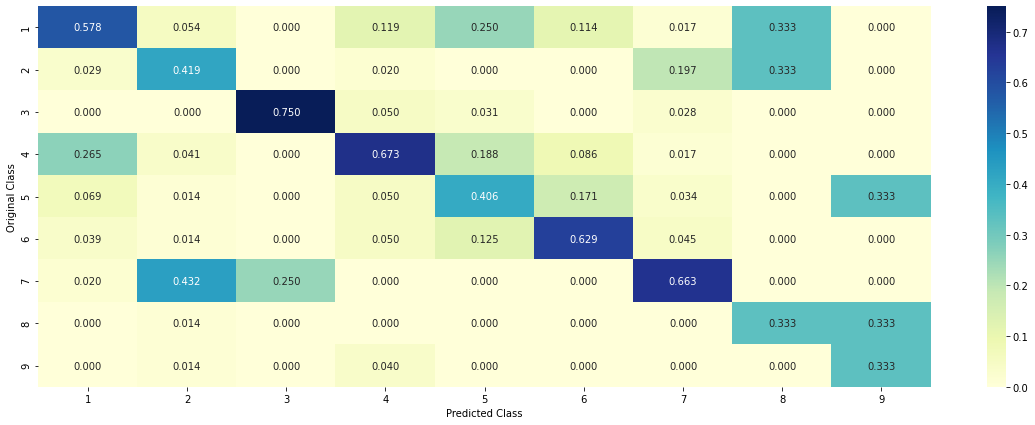

-------------------- Recall matrix (Row sum=1) --------------------


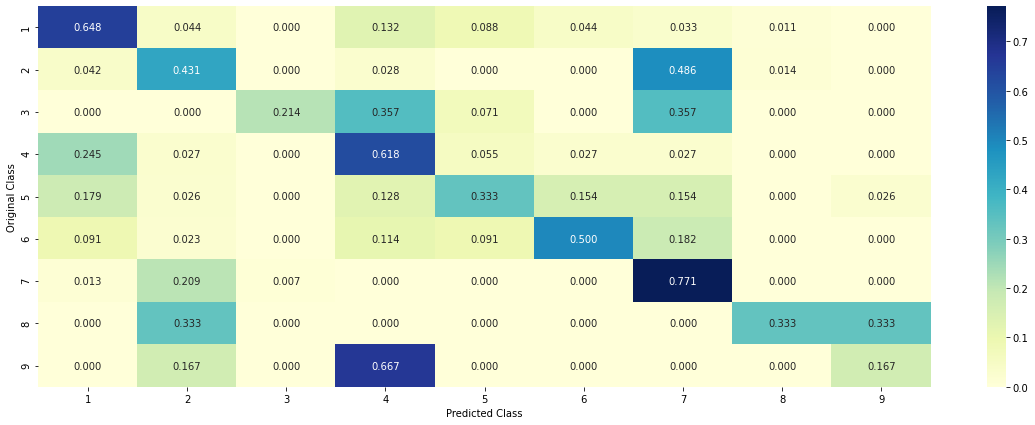

In [78]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

### 4.2.3.Sample Query point -1

In [79]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class:", predicted_cls[0])
print("Actual Class:", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The", alpha[best_alpha]," nearest neighbours of the test points belongs to classes", train_y[neighbors[1][0]])
print("Fequency of nearest points:", Counter(train_y[neighbors[1][0]]))

Predicted Class: 4
Actual Class: 7
The 31  nearest neighbours of the test points belongs to classes [7 3 7 3 3 7 7 3 7 7 3 7 7 3 5 7 7 7 7 7 7 7 7 7 7 4 3 5 7 3 3]
Fequency of nearest points: Counter({7: 19, 3: 9, 5: 2, 4: 1})


### 4.2.4. Sample Query Point-2

In [80]:
clf = KNeighborsClassifier(n_neighbors = alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class:", predicted_cls[0])
print("Actual Class:", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The k value for KNN is",alpha[best_alpha], "and the nearest neighbours of the test points belongs to classes", train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class: 4
Actual Class: 4
The k value for KNN is 31 and the nearest neighbours of the test points belongs to classes [3 3 1 4 4 4 4 5 4 4 4 1 4 1 4 1 4 1 1 4 1 4 4 1 4 4 1 1 1 4 4]
Fequency of nearest points : Counter({4: 17, 1: 11, 3: 2, 5: 1})


## 4.3. Logistic Regression
### 4.3.1. With Class balancing
#### 4.3.1.1. Hyper-parameter tuning

For alpha = 1e-06
Log Loss: 1.399286696117302
For alpha = 1e-05
Log Loss: 1.3518323172334807
For alpha = 0.0001
Log Loss: 1.2018492214226357
For alpha = 0.001
Log Loss: 1.218270133079872
For alpha = 0.01
Log Loss: 1.2881783635341753
For alpha = 0.1
Log Loss: 1.4791195690931043
For alpha = 1
Log Loss: 1.6707496613521868
For alpha = 10
Log Loss: 1.6984803960773742
For alpha = 100
Log Loss: 1.7015400942618522


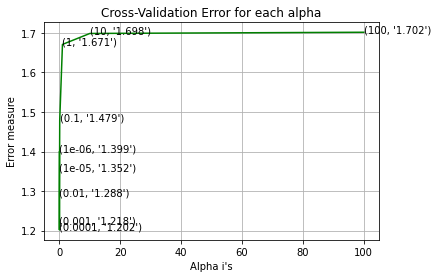

For values of best alpha =  0.0001 The train log loss is: 0.4816203204527439
For values of best alpha =  0.0001 The cross-validation log loss is: 1.2018492214226357
For values of best alpha =  0.0001 The test log loss is: 1.1041276638501627


In [81]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # To avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss:", log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross-Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### 4.3.1.2. Testing the model with best hyper-paramters

Log loss: 1.2018492214226357
Number of mis-classified points: 0.37218045112781956
-------------------- Confusion matrix --------------------


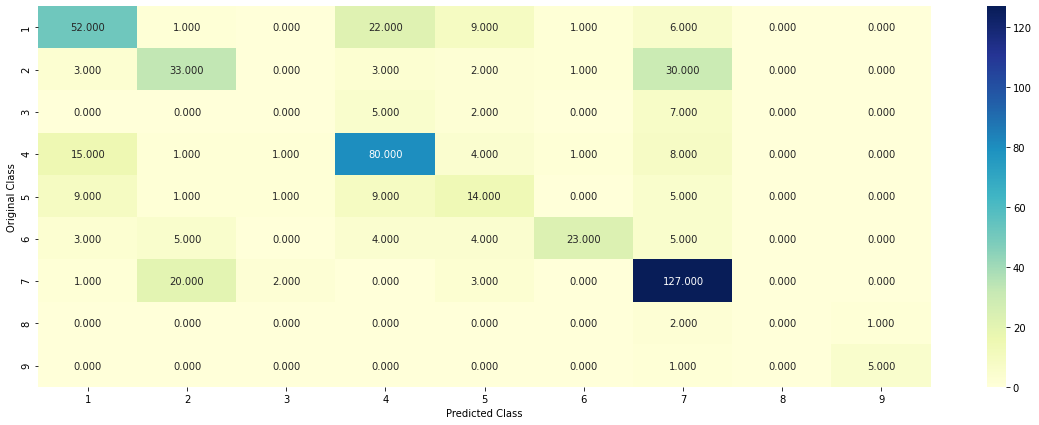

-------------------- Precision matrix (Columm Sum=1) --------------------


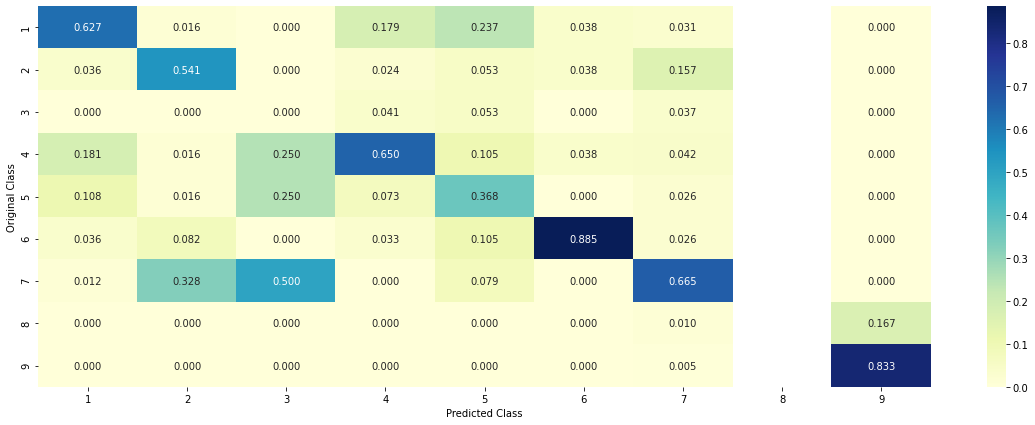

-------------------- Recall matrix (Row sum=1) --------------------


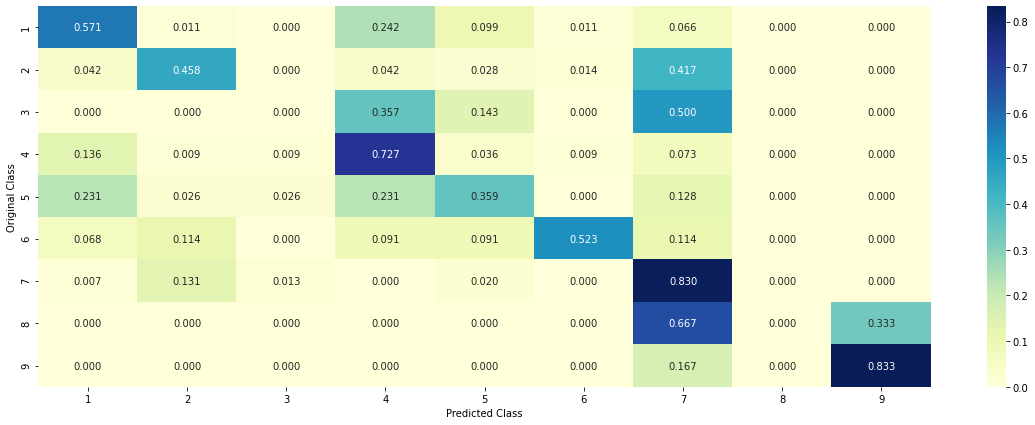

In [82]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', 
    random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### 4.3.1.3. Feature Importance

In [83]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the", predicted_cls[0], "class:")
    print (tabulate(tabulte_list, headers=["Index", 'Feature name', 'Present or Not']))

##### 4.3.1.3.1. Correctly Classified point

In [84]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class:", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class:", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],
    test_df['Gene'].iloc[test_point_index], test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class: 4
Predicted Class Probabilities: [[0.225  0.0858 0.2002 0.3328 0.0381 0.0181 0.0858 0.0079 0.0063]]
Actual Class: 4
--------------------------------------------------
221 Text feature [e285v] present in test data point [True]
Out of the top 500 features 1 are present in query point


##### 4.3.1.3.2. Incorrectly Classified point

In [85]:
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class:", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class:", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],
    test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class: 7
Predicted Class Probabilities: [[0.0255 0.0628 0.1508 0.027  0.0155 0.0156 0.6917 0.0068 0.0044]]
Actual Class: 7
--------------------------------------------------
324 Text feature [nude] present in test data point [True]
476 Text feature [activated] present in test data point [True]
Out of the top 500 features 2 are present in query point


<h3>4.3.2. Without Class balancing</h3>
<h4>4.3.2.1. Hyper-paramter tuning</h4>

For alpha = 1e-06
Log Loss : 1.3739756812481307
For alpha = 1e-05
Log Loss : 1.344518157956145
For alpha = 0.0001
Log Loss : 1.2265817903475966
For alpha = 0.001
Log Loss : 1.2197254005099767
For alpha = 0.01
Log Loss : 1.2961482503065902
For alpha = 0.1
Log Loss : 1.4474448647782614
For alpha = 1
Log Loss : 1.6459642664562073


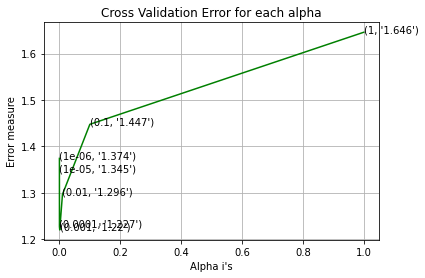

For values of best alpha =  0.001 The train log loss is: 0.49880444988505473
For values of best alpha =  0.001 The cross-validation log loss is: 1.2197254005099767
For values of best alpha =  0.001 The test log loss is: 1.0992028669984268


In [86]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### 4.3.2.2. Testing model with best hyper-parameters

Log loss: 1.2197254005099767
Number of mis-classified points: 0.37406015037593987
-------------------- Confusion matrix --------------------


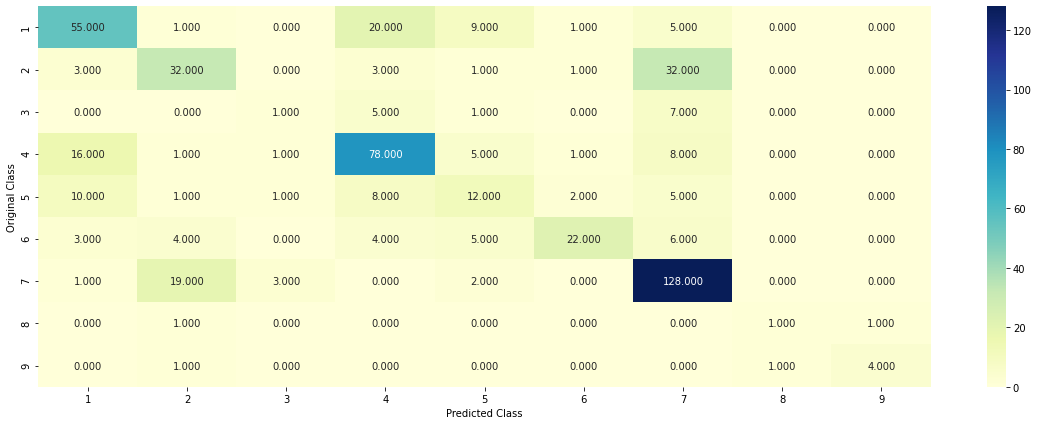

-------------------- Precision matrix (Columm Sum=1) --------------------


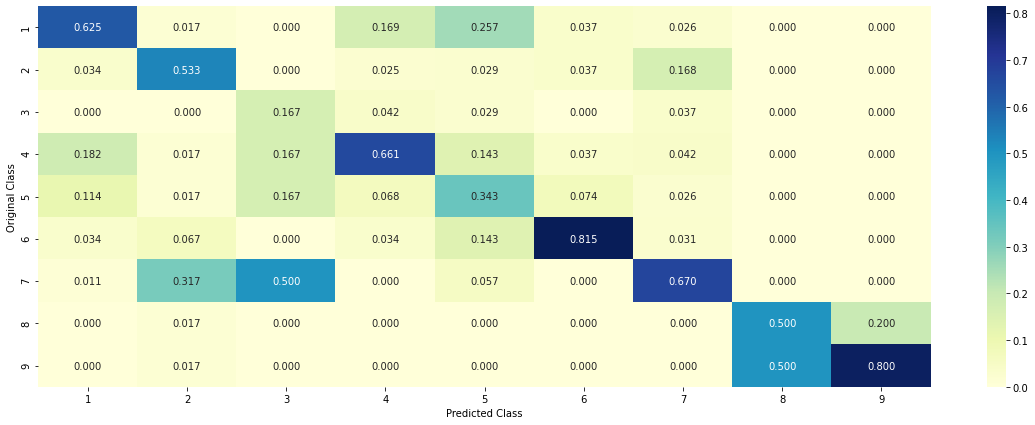

-------------------- Recall matrix (Row sum=1) --------------------


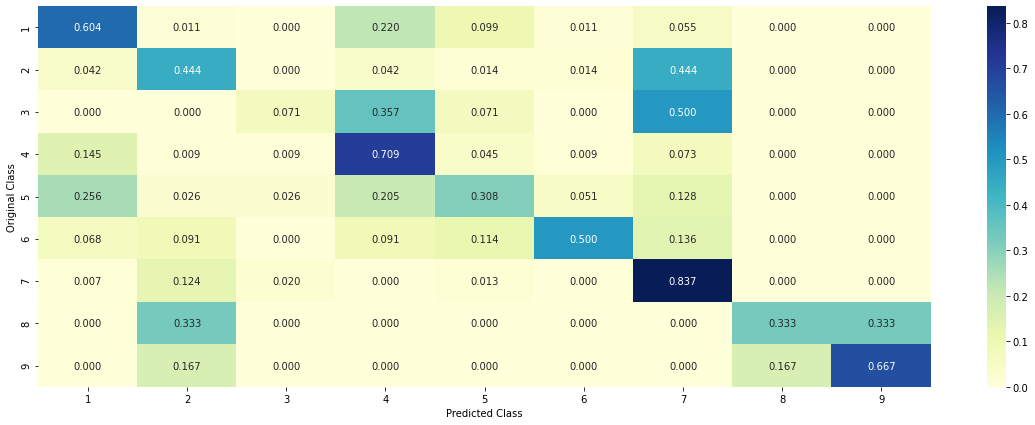

In [87]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### 4.3.2.3. Feature Importance, Correctly Classified point

In [88]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.2145 0.0597 0.1613 0.4596 0.0243 0.023  0.0461 0.0078 0.0037]]
Actual Class : 4
--------------------------------------------------
255 Text feature [e285v] present in test data point [True]
402 Text feature [suppressor] present in test data point [True]
438 Text feature [novel] present in test data point [True]
496 Text feature [harboring] present in test data point [True]
Out of the top 500 features 4 are present in query point


#### 4.3.2.4. Feature Importance, Inorrectly Classified point

In [89]:
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0127 0.0323 0.1622 0.0142 0.01   0.0089 0.7522 0.0059 0.0018]]
Actual Class : 7
--------------------------------------------------
164 Text feature [nude] present in test data point [True]
227 Text feature [activated] present in test data point [True]
280 Text feature [missense] present in test data point [True]
341 Text feature [subcutaneously] present in test data point [True]
344 Text feature [activating] present in test data point [True]
352 Text feature [phospho] present in test data point [True]
359 Text feature [exquisite] present in test data point [True]
412 Text feature [technology] present in test data point [True]
423 Text feature [akt] present in test data point [True]
440 Text feature [activation] present in test data point [True]
443 Text feature [starved] present in test data point [True]
Out of the top 500 features 11 are present in query point


## 4.4. Linear Support Vector Machines
### 4.4.1. Hyper paramter tuning

for C = 1e-05
Log Loss : 1.3721302488847145
for C = 0.0001
Log Loss : 1.329498914588082
for C = 0.001
Log Loss : 1.224173893437524
for C = 0.01
Log Loss : 1.227113903265047
for C = 0.1
Log Loss : 1.4294520696074984
for C = 1
Log Loss : 1.6912707098361786
for C = 10
Log Loss : 1.702080968892639
for C = 100
Log Loss : 1.7020810110262685


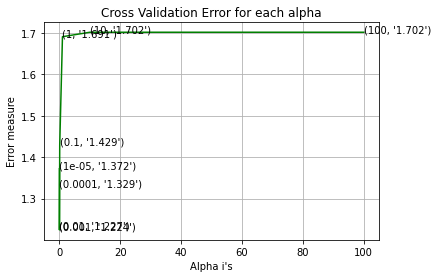

For values of best alpha =  0.001 The train log loss is: 0.5146051070207435
For values of best alpha =  0.001 The cross-validation log loss is: 1.224173893437524
For values of best alpha =  0.001 The test log loss is: 1.1314881221369175


In [90]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    # clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 4.4.2. Testing model with best hyper-parameters

Log loss: 1.224173893437524
Number of mis-classified points: 0.38345864661654133
-------------------- Confusion matrix --------------------


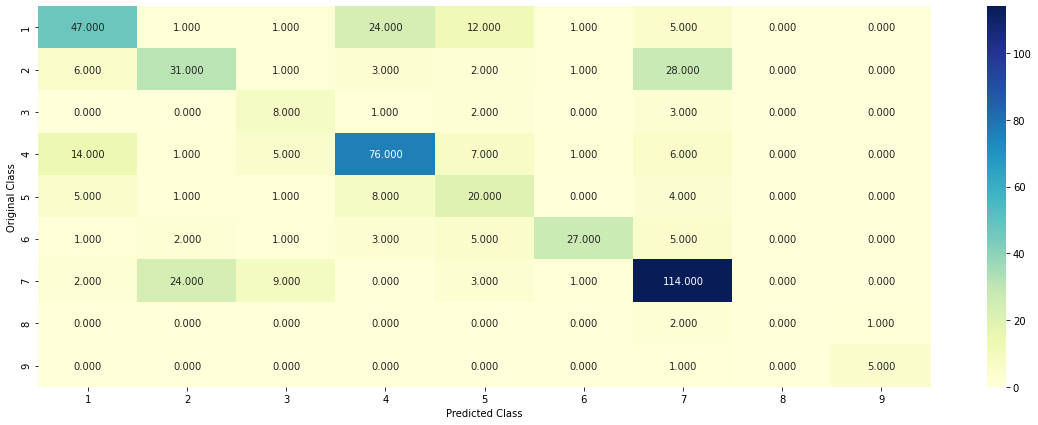

-------------------- Precision matrix (Columm Sum=1) --------------------


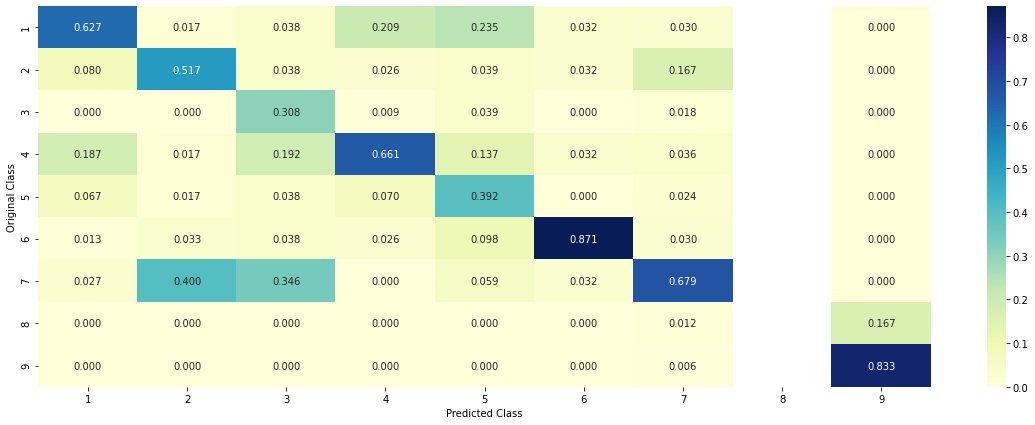

-------------------- Recall matrix (Row sum=1) --------------------


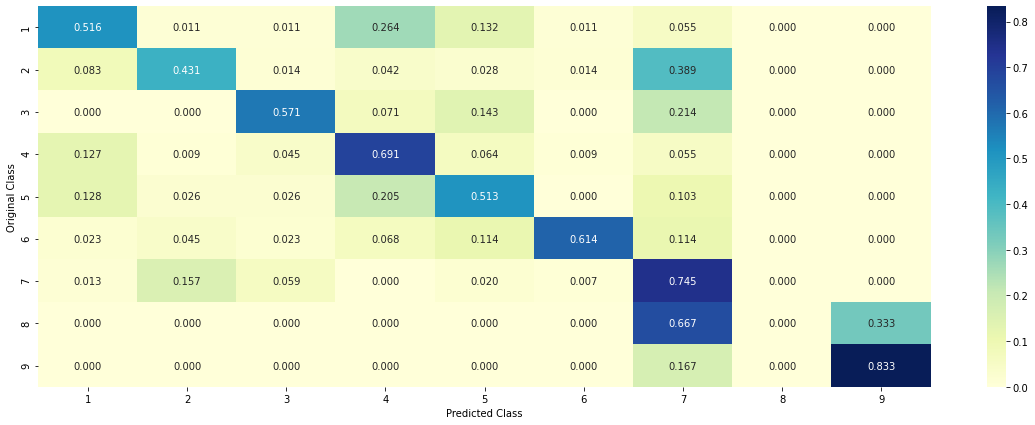

In [91]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,
    class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

### 4.3.3. Feature Importance
#### 4.3.3.1. For Correctly classified point

In [92]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0714 0.0879 0.3097 0.0786 0.0191 0.0322 0.3882 0.0067 0.006 ]]
Actual Class : 7
--------------------------------------------------
397 Text feature [nude] present in test data point [True]
Out of the top 500 features 1 are present in query point


#### 4.3.3.2. For Incorrectly classified point

In [93]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 3
Predicted Class Probabilities: [[0.1315 0.1039 0.3193 0.2062 0.0484 0.0339 0.1422 0.0081 0.0065]]
Actual Class : 4
--------------------------------------------------
90 Text feature [e285v] present in test data point [True]
152 Text feature [al35] present in test data point [True]
Out of the top 500 features 2 are present in query point


## 4.5 Random Forest Classifier
### 4.5.1. Hyper paramter tuning (With One hot Encoding)

In [94]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []

for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2479942362567584
for n_estimators = 100 and max depth =  10
Log Loss : 1.1791742050121312
for n_estimators = 200 and max depth =  5
Log Loss : 1.2276036817618068
for n_estimators = 200 and max depth =  10
Log Loss : 1.1726388304902018
for n_estimators = 500 and max depth =  5
Log Loss : 1.2218079860284239
for n_estimators = 500 and max depth =  10
Log Loss : 1.1653745682322734
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2192901051825111
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1660086101573832
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2180106154407166
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1643616726206891


KeyboardInterrupt: 

### 4.5.2. Testing model with best hyper parameters (One Hot Encoding)

Log loss: 1.1643616726206891
Number of mis-classified points: 0.40037593984962405
-------------------- Confusion matrix --------------------


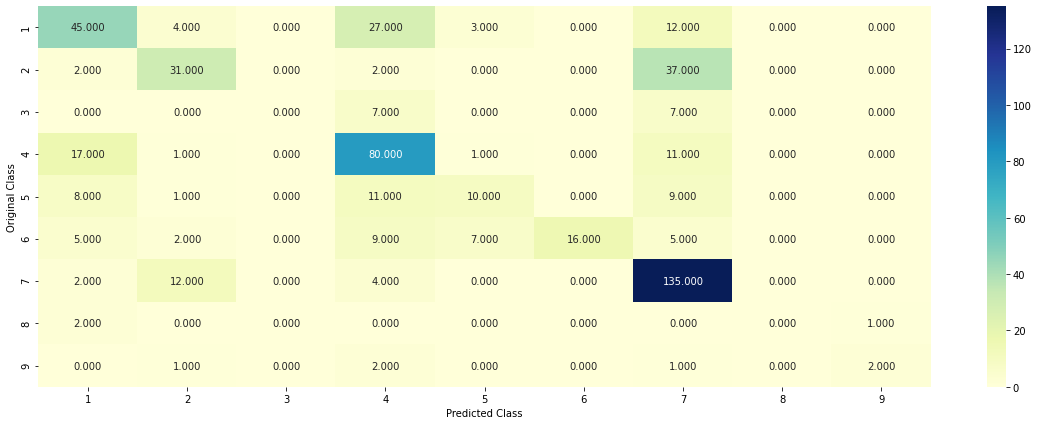

-------------------- Precision matrix (Columm Sum=1) --------------------


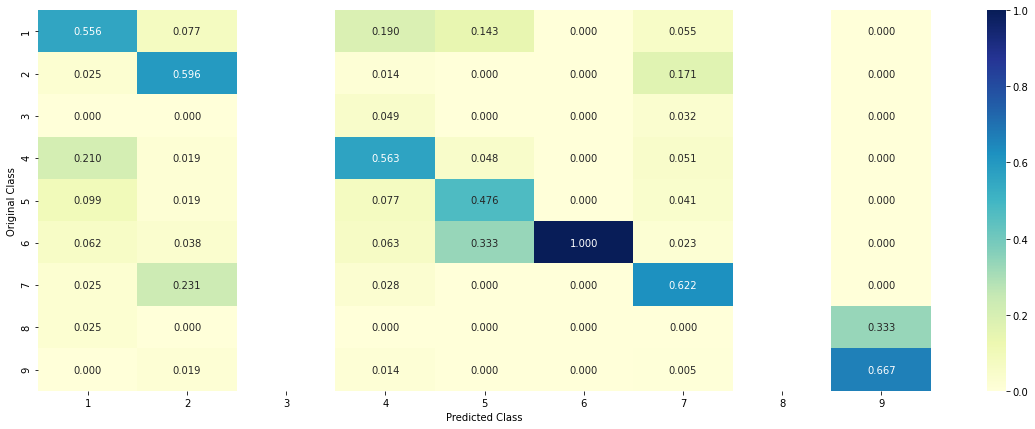

-------------------- Recall matrix (Row sum=1) --------------------


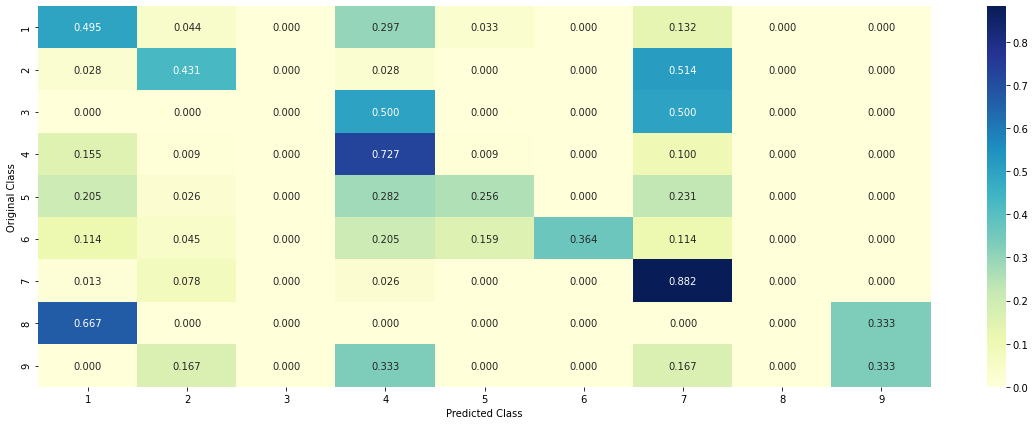

In [95]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', 
    max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

### 4.5.3. Feature Importance
#### 4.5.3.1. Correctly Classified point

In [96]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.2788 0.0682 0.0368 0.4381 0.0574 0.0505 0.0543 0.008  0.0079]]
Actual Class : 4
--------------------------------------------------
6 Text feature [suppressor] present in test data point [True]
10 Text feature [function] present in test data point [True]
12 Text feature [signaling] present in test data point [True]
15 Text feature [nonsense] present in test data point [True]
19 Text feature [treatment] present in test data point [True]
20 Text feature [trials] present in test data point [True]
32 Text feature [frameshift] present in test data point [True]
35 Text feature [loss] present in test data point [True]
40 Text feature [variants] present in test data point [True]
43 Text feature [cells] present in test data point [True]
49 Text feature [patients] present in test data point [True]
52 Text feature [expressing] present in test data point [True]
54 Text feature [functional] present in test data point [True]
55 Text feature [cell

#### 4.5.3.2. Inorrectly Classified point

In [97]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0415 0.0738 0.0427 0.0503 0.0399 0.0355 0.7041 0.0064 0.0057]]
Actuall Class : 7
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
2 Text feature [inhibitors] present in test data point [True]
3 Text feature [activated] present in test data point [True]
4 Text feature [activation] present in test data point [True]
7 Text feature [akt] present in test data point [True]
10 Text feature [function] present in test data point [True]
11 Text feature [missense] present in test data point [True]
12 Text feature [signaling] present in test data point [True]
13 Text feature [phosphorylation] present in test data point [True]
14 Text feature [oncogenic] present in test data point [True]
16 Text feature [inhibitor] present in test data point [True]
18 Text feature [therapy] present in test data point [True]
19 Text feature [

### 4.5.3. Hyper-parameter tuning (With Response Coding)

In [98]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []

for i in alpha:
    for j in max_depth:
        print("For n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For n_estimators = 10 and max depth =  2
Log Loss : 2.1019084055684174
For n_estimators = 10 and max depth =  3
Log Loss : 1.650732448121501
For n_estimators = 10 and max depth =  5
Log Loss : 1.6101006074213648
For n_estimators = 10 and max depth =  10
Log Loss : 1.7186003447810922
For n_estimators = 50 and max depth =  2
Log Loss : 1.624388316192522
For n_estimators = 50 and max depth =  3
Log Loss : 1.3995662632928176
For n_estimators = 50 and max depth =  5
Log Loss : 1.405765379807342
For n_estimators = 50 and max depth =  10
Log Loss : 1.7121859816059206
For n_estimators = 100 and max depth =  2
Log Loss : 1.5241058830970764
For n_estimators = 100 and max depth =  3
Log Loss : 1.4388405920017504
For n_estimators = 100 and max depth =  5
Log Loss : 1.3749873895067148
For n_estimators = 100 and max depth =  10
Log Loss : 1.711382499330227
For n_estimators = 200 and max depth =  2
Log Loss : 1.5669073194541674
For n_estimators = 200 and max depth =  3
Log Loss : 1.4448929394878829
F

### 4.5.4. Testing model with best hyper-parameters (Response Coding)

Log loss: 1.3749873895066904
Number of mis-classified points: 0.5018796992481203
-------------------- Confusion matrix --------------------


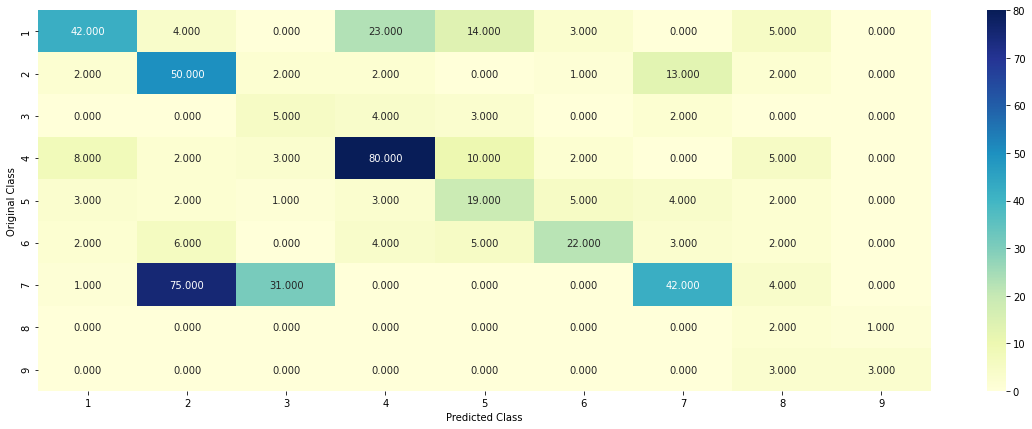

-------------------- Precision matrix (Columm Sum=1) --------------------


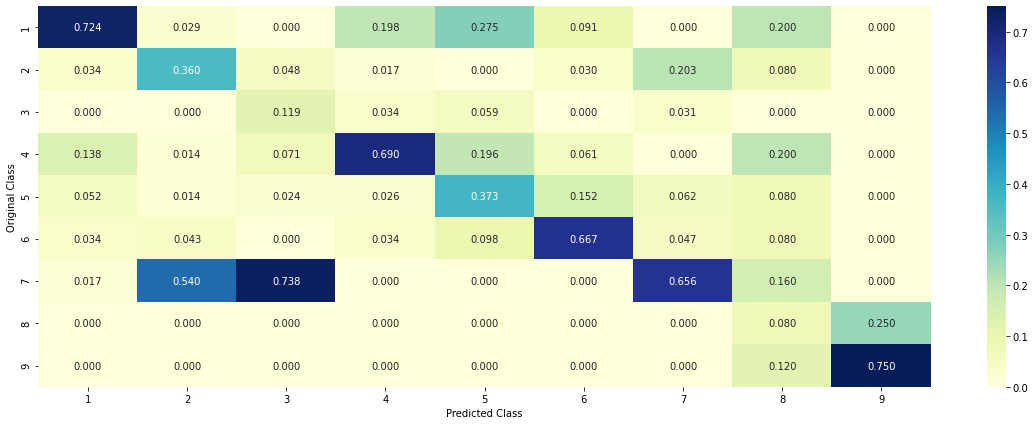

-------------------- Recall matrix (Row sum=1) --------------------


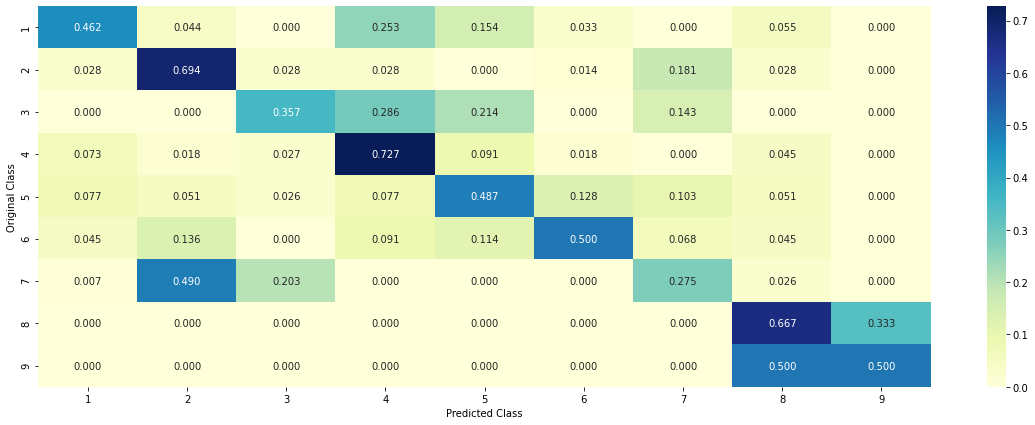

In [99]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], 
    criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

### 4.5.5. Feature Importance
#### 4.5.5.1. Correctly Classified point

In [100]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 3
Predicted Class Probabilities: [[0.0144 0.0641 0.6888 0.0175 0.0216 0.0213 0.1374 0.0264 0.0085]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


#### 4.5.5.2. Incorrectly Classified point

In [101]:
test_point_index = 3
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 2
Predicted Class Probabilities: [[0.0165 0.3224 0.0698 0.0276 0.0335 0.2639 0.1106 0.1448 0.0108]]
Actual Class : 2
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


## 4.7 Stack the models 
### 4.7.1 Testing with hyper-parameter tuning

In [102]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)

alpha = [0.0001,0.001,0.01,0.1,1] 
best_loss = 999
best_alpha = 999

for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    print("Stacking Classifer: For the value of alpha: %f Log Loss: %0.3f" % (i, log_error))
    if best_loss > log_error:
        best_loss = log_error
        best_alpha = i

Logistic Regression :  Log Loss: 1.22
Support vector machines : Log Loss: 1.69
Naive Bayes : Log Loss: 1.29
--------------------------------------------------
Stacking Classifer: For the value of alpha: 0.000100 Log Loss: 1.818
Stacking Classifer: For the value of alpha: 0.001000 Log Loss: 1.725
Stacking Classifer: For the value of alpha: 0.010000 Log Loss: 1.350
Stacking Classifer: For the value of alpha: 0.100000 Log Loss: 1.252
Stacking Classifer: For the value of alpha: 1.000000 Log Loss: 1.617


### 4.7.2 Testing the model with the best hyper-parameters

Log loss (train) on the stacking classifier: 0.46942164975466083
Log loss (CV) on the stacking classifier: 1.2519994034266948
Log loss (test) on the stacking classifier: 1.1768073119381588
Number of missclassified points: 0.3804511278195489
-------------------- Confusion matrix --------------------


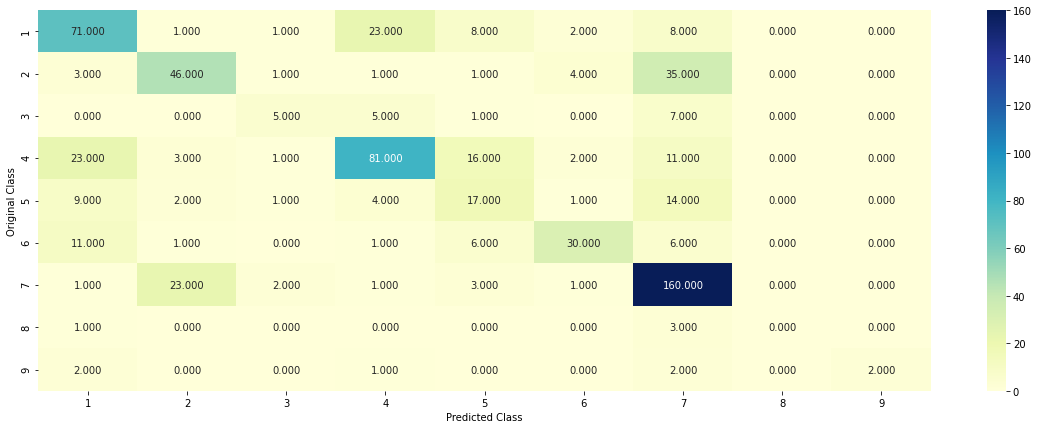

-------------------- Precision matrix (Columm Sum=1) --------------------


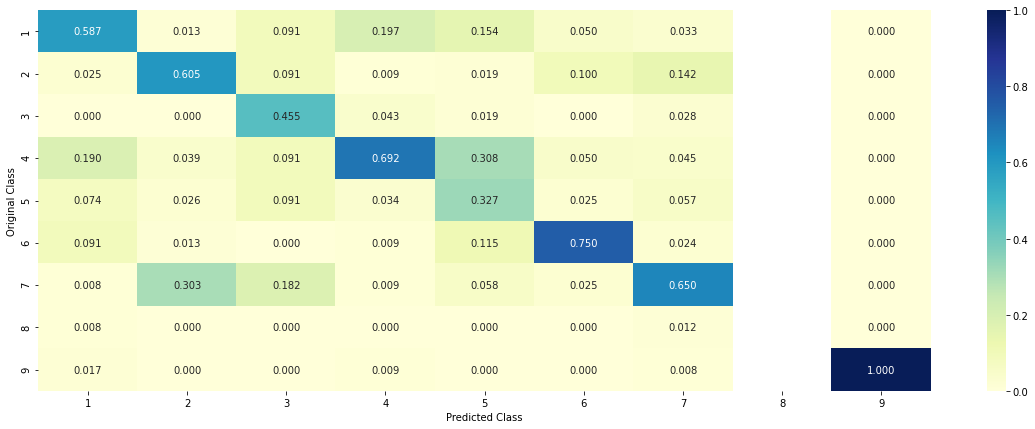

-------------------- Recall matrix (Row sum=1) --------------------


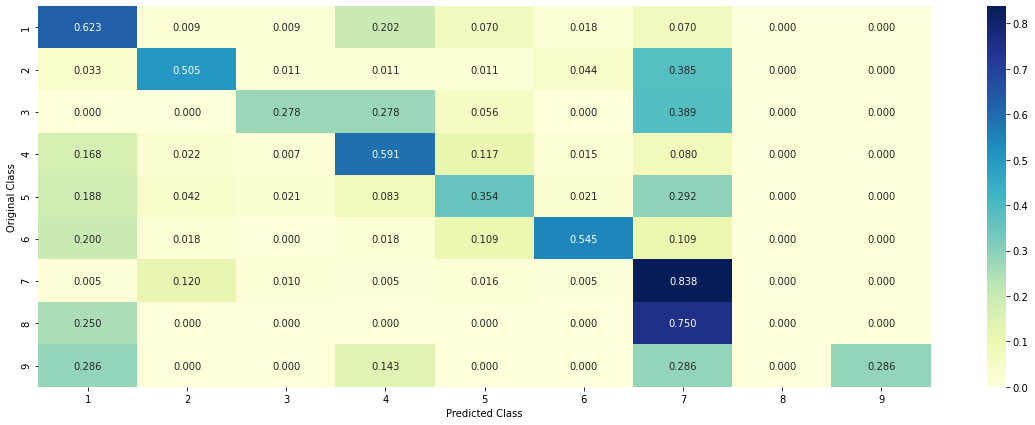

In [103]:
lr = LogisticRegression(C=best_alpha)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier:", log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier:", log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier:", log_error)

print("Number of missclassified points:", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

### 4.7.3 Maximum Voting Classifier

Log loss (train) on the VotingClassifier : 0.830018201170401
Log loss (CV) on the VotingClassifier : 1.216224592348604
Log loss (test) on the VotingClassifier : 1.2176191677293768
Number of missclassified point : 0.3774436090225564
-------------------- Confusion matrix --------------------


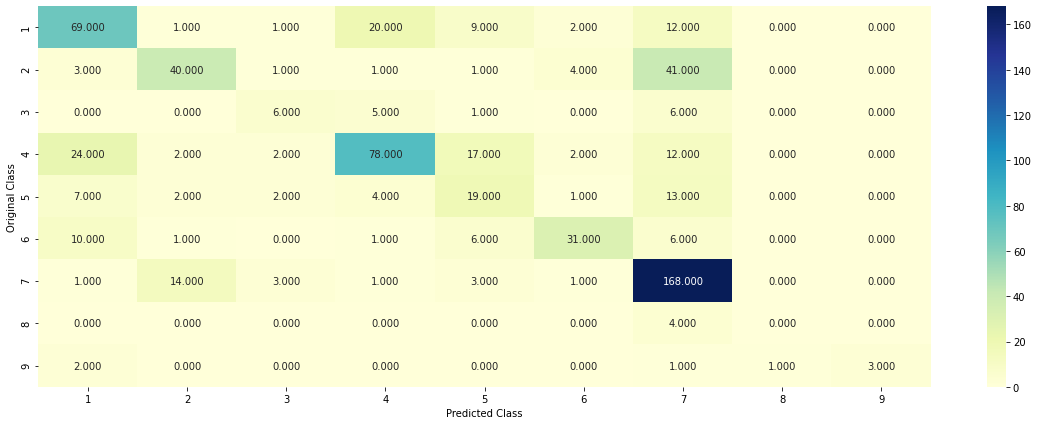

-------------------- Precision matrix (Columm Sum=1) --------------------


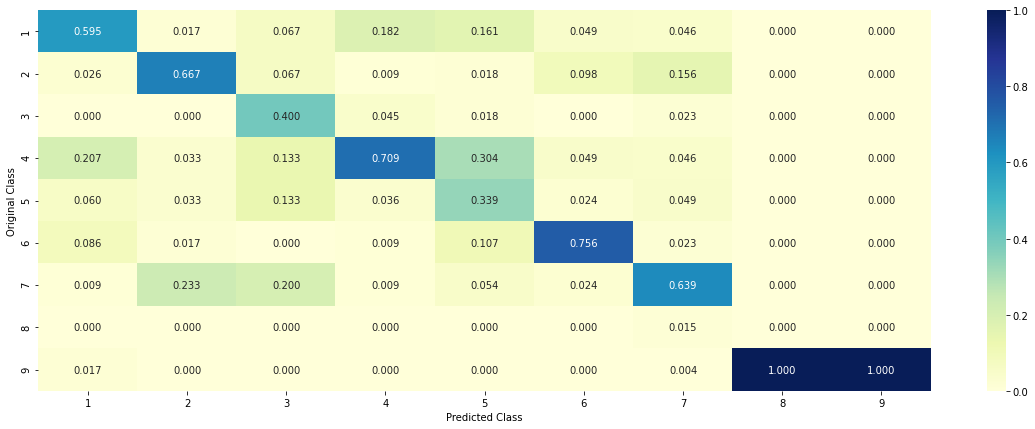

-------------------- Recall matrix (Row sum=1) --------------------


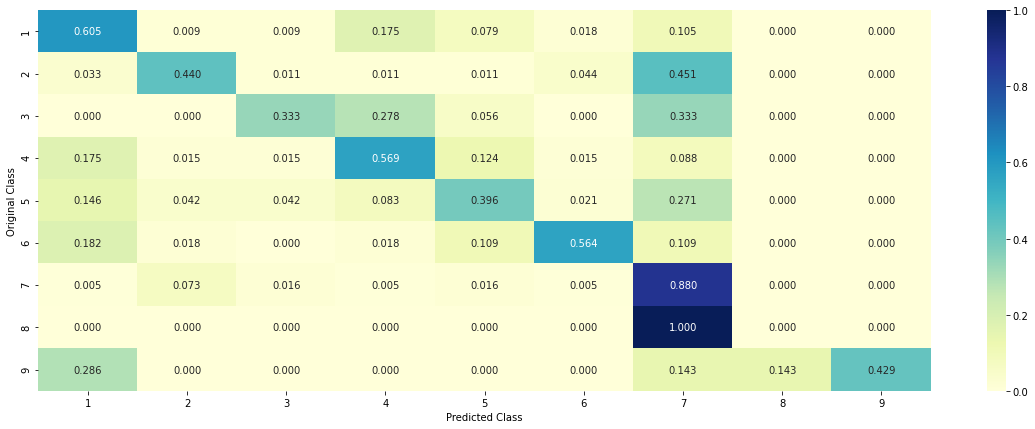

In [104]:
# Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))

# 5. Further Extensions
- Apply all the models with tf-idf features (Replace CountVectorizer with tfidfVectorizer and run the same cells)
- Instead of using all the words in the dataset, use only the top 1000 words based of tf-idf values
- Apply Logistic regression with CountVectorizer Features, including both unigrams and bigrams
- Try any of the feature engineering techniques discussed in the course to reduce the CV and test log-loss to a value less than 1.0

## 5.1 Using TF-IDF Features
- For this sub-section, we will stack TF-IDF based featurization of the text with one-hot encoded representations of gene and variance.
- From all the models, we have tried till now, we will leave a couple of models, which doesn't provide good results with TF-IDF Features.
- We will be leaving the KNN model since KNN model is not known to performing well in the case of high-dimensionalities due to the curse of dimensionionality.

In [105]:
# Listing the variables we already have
print(train_gene_var_onehotCoding.shape, test_gene_var_onehotCoding.shape, cv_gene_var_onehotCoding.shape)
print(train_y.shape, test_y.shape, cv_y.shape)

tfidf_text_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature_tfidf = tfidf_text_vectorizer.fit_transform(train_df['TEXT'])
test_text_feature_tfidf = tfidf_text_vectorizer.transform(test_df['TEXT'])
cv_text_feature_tfidf = tfidf_text_vectorizer.transform(cv_df['TEXT'])

print(train_text_feature_tfidf.shape, test_text_feature_tfidf.shape, cv_text_feature_tfidf.shape)

train_x_tfidf = hstack((train_gene_var_onehotCoding, train_text_feature_tfidf)).tocsr()
test_x_tfidf = hstack((test_gene_var_onehotCoding, test_text_feature_tfidf)).tocsr()
cv_x_tfidf = hstack((cv_gene_var_onehotCoding, cv_text_feature_tfidf)).tocsr()

print("\nOne-hot Encoding (Gene & Variation) + TF-IDF (Text) features:")
print("(Number of data points * Number of features) in train data =", train_x_tfidf.shape)
print("(Number of data points * Number of features) in test data =", test_x_tfidf.shape)
print("(Number of data points * Number of features) in cross-validation data =", cv_x_tfidf.shape)

(2124, 2178) (665, 2178) (532, 2178)
(2124,) (665,) (532,)
(2124, 53365) (665, 53365) (532, 53365)

One-hot Encoding (Gene & Variation) + TF-IDF (Text) features:
(Number of data points * Number of features) in train data = (2124, 55543)
(Number of data points * Number of features) in test data = (665, 55543)
(Number of data points * Number of features) in cross-validation data = (532, 55543)


### 5.1.1 Naive Bayes + Hyper-parameter Tuning

For alpha = 1e-05
Log Loss: 1.2304546245200352
For alpha = 0.0001
Log Loss: 1.2358591502570262
For alpha = 0.001
Log Loss: 1.2386553553906556
For alpha = 0.1
Log Loss: 1.2586219956148776
For alpha = 1
Log Loss: 1.279792050374345
For alpha = 10
Log Loss: 1.2759097248626985
For alpha = 100
Log Loss: 1.2923740499212577
For alpha = 1000
Log Loss: 1.294661485185525


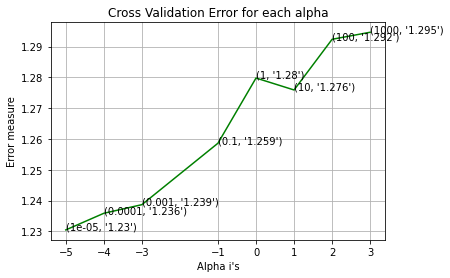

For values of best alpha =  1e-05 The train log loss is: 0.5137475079787526
For values of best alpha =  1e-05 The cross-validation log loss is: 1.2304546245200352
For values of best alpha =  1e-05 The test log loss is: 1.242467774208984


In [106]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss:", log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
    
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 5.1.2 Logistic Regression + Class Balancing + Hyper-parameter Tuning

For alpha = 1e-06
Log Loss: 1.1457542064886082
For alpha = 1e-05
Log Loss: 1.0178981430783292
For alpha = 0.0001
Log Loss: 0.9974244221793159
For alpha = 0.001
Log Loss: 1.064296959376986
For alpha = 0.01
Log Loss: 1.2213897025145959
For alpha = 0.1
Log Loss: 1.4137660470686697
For alpha = 1
Log Loss: 1.4875905573529797
For alpha = 10
Log Loss: 1.4991532575284479
For alpha = 100
Log Loss: 1.500567149657882


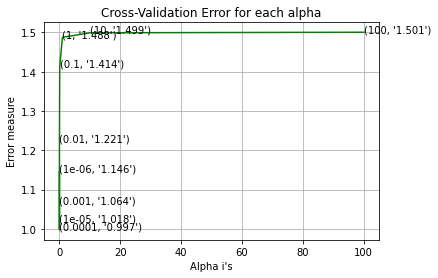

For values of best alpha =  0.0001 The train log loss is: 0.3589920604948733
For values of best alpha =  0.0001 The cross-validation log loss is: 0.9974244221793159
For values of best alpha =  0.0001 The test log loss is: 0.9928989872163153


In [107]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss:", log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross-Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 5.1.3 Logistic Regression + Without Class Balancing + Hyper-parameter Tuning

For alpha = 1e-06
Log Loss: 1.1641626977059019
For alpha = 1e-05
Log Loss: 1.023740144954165
For alpha = 0.0001
Log Loss: 0.9988713213225717
For alpha = 0.001
Log Loss: 1.0551324628599814
For alpha = 0.01
Log Loss: 1.2088398164325729
For alpha = 0.1
Log Loss: 1.360996164685438
For alpha = 1
Log Loss: 1.4422490865894804
For alpha = 10
Log Loss: 1.4538418306495808
For alpha = 100
Log Loss: 1.4552540349712428


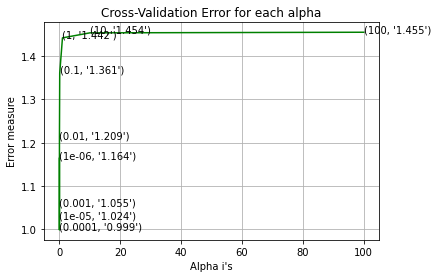

For values of best alpha =  0.0001 The train log loss is: 0.35136596238038326
For values of best alpha =  0.0001 The cross-validation log loss is: 0.9988713213225717
For values of best alpha =  0.0001 The test log loss is: 0.9939709176387025


In [108]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss:", log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross-Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 5.1.4 Linear Support Vector Machines + Class Balancing + Hyper-parameter Tuning

for C = 1e-05
Log Loss : 1.1062333088034702
for C = 0.0001
Log Loss : 1.0390701856013458
for C = 0.001
Log Loss : 1.1351401953664415
for C = 0.01
Log Loss : 1.2996372130688796
for C = 0.1
Log Loss : 1.443438118380852
for C = 1
Log Loss : 1.5009892978516668
for C = 10
Log Loss : 1.5009891554561463
for C = 100
Log Loss : 1.5009891506625965


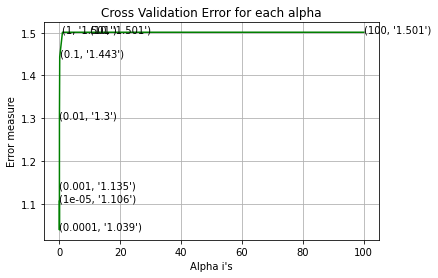

For values of best alpha =  0.0001 The train log loss is: 0.30715926043047787
For values of best alpha =  0.0001 The cross-validation log loss is: 1.0390701856013458
For values of best alpha =  0.0001 The test log loss is: 1.0375114123871259


In [109]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []

for i in alpha:
    print("for C =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 5.1.5 Random Forest + Hyper-parameter Tuning

In [110]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []

for i in alpha:
    for j in max_depth:
        print("For n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_tfidf, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_tfidf, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For n_estimators = 100 and max depth =  5
Log Loss : 1.3054617726391358
For n_estimators = 100 and max depth =  10
Log Loss : 1.2794027083353583
For n_estimators = 200 and max depth =  5
Log Loss : 1.2931820998880057
For n_estimators = 200 and max depth =  10
Log Loss : 1.2798570286920947
For n_estimators = 500 and max depth =  5
Log Loss : 1.2878643723328453
For n_estimators = 500 and max depth =  10
Log Loss : 1.279765550883833
For n_estimators = 1000 and max depth =  5
Log Loss : 1.2861304611872069
For n_estimators = 1000 and max depth =  10
Log Loss : 1.2774416773179882
For n_estimators = 2000 and max depth =  5
Log Loss : 1.2857905941992942
For n_estimators = 2000 and max depth =  10
Log Loss : 1.2755284835417375
For values of best estimator =  2000 The train log loss is: 1.278403742115413
For values of best estimator =  2000 The cross-validation log loss is: 1.3544494886716874
For values of best estimator =  2000 The test log loss is: 1.3871554087647509


## 5.2 Using TF-IDF Top 1000 Features
- For this sub-section as well, we will stack TF-IDF based featurization of the text with one-hot encoded representations of gene and variance.
- Once again, we will select a couple of models only, but this time, we will use the KNN model as well, due to lesser dimensionality of the resulting dataset

In [111]:
# Listing the variables we already have
print(train_gene_var_onehotCoding.shape, test_gene_var_onehotCoding.shape, cv_gene_var_onehotCoding.shape)
print(train_y.shape, test_y.shape, cv_y.shape)

tfidf_text_vectorizer = TfidfVectorizer(min_df=3, max_features=1000)
train_text_feature_tfidf = tfidf_text_vectorizer.fit_transform(train_df['TEXT'])
test_text_feature_tfidf = tfidf_text_vectorizer.transform(test_df['TEXT'])
cv_text_feature_tfidf = tfidf_text_vectorizer.transform(cv_df['TEXT'])

print(train_text_feature_tfidf.shape, test_text_feature_tfidf.shape, cv_text_feature_tfidf.shape)

train_x_tfidf = hstack((train_gene_var_onehotCoding, train_text_feature_tfidf)).tocsr()
test_x_tfidf = hstack((test_gene_var_onehotCoding, test_text_feature_tfidf)).tocsr()
cv_x_tfidf = hstack((cv_gene_var_onehotCoding, cv_text_feature_tfidf)).tocsr()

print("\nOne-hot Encoding (Gene & Variation) + TF-IDF (Text) features:")
print("(Number of data points * Number of features) in train data =", train_x_tfidf.shape)
print("(Number of data points * Number of features) in test data =", test_x_tfidf.shape)
print("(Number of data points * Number of features) in cross-validation data =", cv_x_tfidf.shape)

(2124, 2178) (665, 2178) (532, 2178)
(2124,) (665,) (532,)
(2124, 1000) (665, 1000) (532, 1000)

One-hot Encoding (Gene & Variation) + TF-IDF (Text) features:
(Number of data points * Number of features) in train data = (2124, 3178)
(Number of data points * Number of features) in test data = (665, 3178)
(Number of data points * Number of features) in cross-validation data = (532, 3178)


### 5.2.1 Naive Bayes + Hyper-parameter Tuning

For alpha = 1e-05
Log Loss: 1.2407341696308416
For alpha = 0.0001
Log Loss: 1.241087329433068
For alpha = 0.001
Log Loss: 1.240266524045699
For alpha = 0.1
Log Loss: 1.2409193187859358
For alpha = 1
Log Loss: 1.2335148803467006
For alpha = 10
Log Loss: 1.2907183049423614
For alpha = 100
Log Loss: 1.318209493175386
For alpha = 1000
Log Loss: 1.3249072871001235


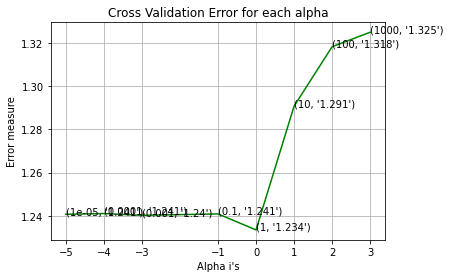

For values of best alpha =  1 The train log loss is: 0.91340795353142
For values of best alpha =  1 The cross-validation log loss is: 1.2335148803467006
For values of best alpha =  1 The test log loss is: 1.2572073593100221


In [112]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss:", log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
    
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 5.2.2 KNN + Hyper-parameter Tuning

For alpha = 5
Log Loss: 1.161479442490389
For alpha = 11
Log Loss: 1.1938380292333814
For alpha = 15
Log Loss: 1.192389289301786
For alpha = 21
Log Loss: 1.2233627112574568
For alpha = 31
Log Loss: 1.2535072239446359
For alpha = 41
Log Loss: 1.2672529792597316
For alpha = 51
Log Loss: 1.2811703694450651
For alpha = 99
Log Loss: 1.3209588080851795


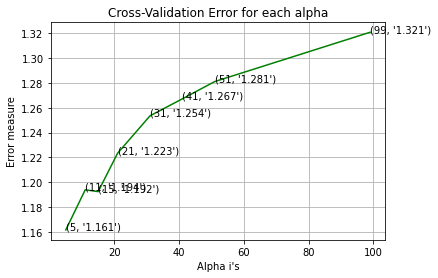

For values of best alpha = 5 The train log loss is: 0.8155064315083902
For values of best alpha = 5 The cross-validation log loss is: 1.161479442490389
For values of best alpha = 5 The test log loss is: 1.1520169142659518


In [113]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss:", log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross-Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha =', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha =', alpha[best_alpha], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha =', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 5.2.3 Logistic Regression + Class Balancing + Hyper-parameter Tuning

For alpha = 1e-06
Log Loss: 1.1514217884427194
For alpha = 1e-05
Log Loss: 1.0728016698569465
For alpha = 0.0001
Log Loss: 1.0473161722549986
For alpha = 0.001
Log Loss: 1.0900350338767473
For alpha = 0.01
Log Loss: 1.245347268152346
For alpha = 0.1
Log Loss: 1.505332549343486
For alpha = 1
Log Loss: 1.5971339059841143
For alpha = 10
Log Loss: 1.6095892404351038
For alpha = 100
Log Loss: 1.6110449674825635


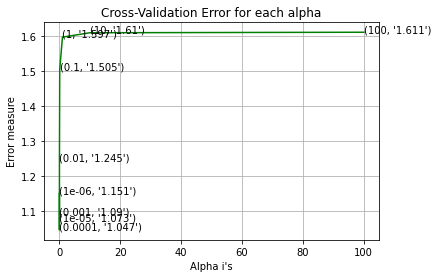

For values of best alpha =  0.0001 The train log loss is: 0.4052843285518096
For values of best alpha =  0.0001 The cross-validation log loss is: 1.0473161722549986
For values of best alpha =  0.0001 The test log loss is: 1.0389879887862403


In [114]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss:", log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross-Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 5.2.4 Logistic Regression + Without Class Balancing + Hyper-parameter Tuning

For alpha = 1e-06
Log Loss: 1.149238333552186
For alpha = 1e-05
Log Loss: 1.0781013765362155
For alpha = 0.0001
Log Loss: 1.0521609460080266
For alpha = 0.001
Log Loss: 1.0997925385113927
For alpha = 0.01
Log Loss: 1.2252377138130992
For alpha = 0.1
Log Loss: 1.423955862695758
For alpha = 1
Log Loss: 1.531307967875812
For alpha = 10
Log Loss: 1.546017783825543
For alpha = 100
Log Loss: 1.5477414812230859


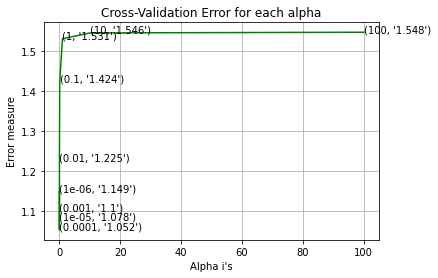

For values of best alpha =  0.0001 The train log loss is: 0.39596765001325473
For values of best alpha =  0.0001 The cross-validation log loss is: 1.0521609460080266
For values of best alpha =  0.0001 The test log loss is: 1.0408792746499589


In [115]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss:", log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross-Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 5.2.5 Linear Support Vector Machines + Class Balancing + Hyper-parameter Tuning

for C = 1e-05
Log Loss : 1.1152828193720714
for C = 0.0001
Log Loss : 1.0874488616896285
for C = 0.001
Log Loss : 1.179536335835992
for C = 0.01
Log Loss : 1.3436594281260439
for C = 0.1
Log Loss : 1.550285690182831
for C = 1
Log Loss : 1.6114251416548038
for C = 10
Log Loss : 1.6114251644501079
for C = 100
Log Loss : 1.6114251531874189


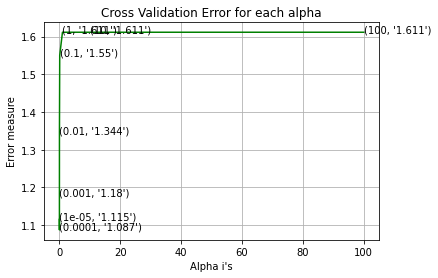

For values of best alpha =  0.0001 The train log loss is: 0.33308336098999475
For values of best alpha =  0.0001 The cross-validation log loss is: 1.0874488616896285
For values of best alpha =  0.0001 The test log loss is: 1.0762879218408024


In [116]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []

for i in alpha:
    print("for C =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 5.2.6 Random Forest + Hyper-parameter Tuning

In [117]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []

for i in alpha:
    for j in max_depth:
        print("For n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_tfidf, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_tfidf, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For n_estimators = 100 and max depth =  5
Log Loss : 1.116661648449508
For n_estimators = 100 and max depth =  10
Log Loss : 1.0966756500094883
For n_estimators = 200 and max depth =  5
Log Loss : 1.1129954354909821
For n_estimators = 200 and max depth =  10
Log Loss : 1.0927261057773006
For n_estimators = 500 and max depth =  5
Log Loss : 1.10200226877754
For n_estimators = 500 and max depth =  10
Log Loss : 1.0896541900615484
For n_estimators = 1000 and max depth =  5
Log Loss : 1.101325253024693
For n_estimators = 1000 and max depth =  10
Log Loss : 1.089552075475019
For n_estimators = 2000 and max depth =  5
Log Loss : 1.102161261656103
For n_estimators = 2000 and max depth =  10
Log Loss : 1.0893140691115193
For values of best estimator =  2000 The train log loss is: 0.4848322469474956
For values of best estimator =  2000 The cross-validation log loss is: 1.0893140691115193
For values of best estimator =  2000 The test log loss is: 1.0872438890667986


## 5.3 Logistic Regression + Count Vectorizer (Both Unigrams & Bigrams)

In [118]:
# Listing the variables we already have
print(train_gene_var_onehotCoding.shape, test_gene_var_onehotCoding.shape, cv_gene_var_onehotCoding.shape)
print(train_y.shape, test_y.shape, cv_y.shape)

text_vectorizer = CountVectorizer(min_df=3, ngram_range=(1, 2))
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])

print(train_text_feature_onehotCoding.shape, test_text_feature_onehotCoding.shape, 
    cv_text_feature_onehotCoding.shape)

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()

print("\nOne-hot Encoding (Gene & Variation) + TF-IDF (Text) features:")
print("(Number of data points * Number of features) in train data =", train_x_onehotCoding.shape)
print("(Number of data points * Number of features) in test data =", test_x_onehotCoding.shape)
print("(Number of data points * Number of features) in cross-validation data =", cv_x_onehotCoding.shape)

(2124, 2178) (665, 2178) (532, 2178)
(2124,) (665,) (532,)
(2124, 778904) (665, 778904) (532, 778904)

One-hot Encoding (Gene & Variation) + TF-IDF (Text) features:
(Number of data points * Number of features) in train data = (2124, 781082)
(Number of data points * Number of features) in test data = (665, 781082)
(Number of data points * Number of features) in cross-validation data = (532, 781082)


### 5.3.1 With Class Balancing + Hyper-parameter Tuning

For alpha = 1e-06
Log Loss: 1.8308894149805628
For alpha = 1e-05
Log Loss: 1.8308894149805628
For alpha = 0.0001
Log Loss: 1.8308894149805628
For alpha = 0.001
Log Loss: 1.3449726407948523
For alpha = 0.01
Log Loss: 1.290504441807488
For alpha = 0.1
Log Loss: 1.3050187767619927
For alpha = 1
Log Loss: 1.2060157719914582
For alpha = 10
Log Loss: 1.1943360768482585
For alpha = 100
Log Loss: 1.3226995940771058


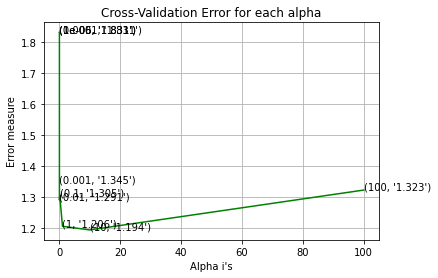

For values of best alpha =  10 The train log loss is: 0.8084328901084481
For values of best alpha =  10 The cross-validation log loss is: 1.1943360768482585
For values of best alpha =  10 The test log loss is: 1.1872970376582221


In [119]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss:", log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross-Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 5.3.2 Without Class Balancing + Hyper-parameter Tuning

For alpha = 1e-06
Log Loss : 1.8308894149805628
For alpha = 1e-05
Log Loss : 1.8308894149805628
For alpha = 0.0001
Log Loss : 1.8308894149805628
For alpha = 0.001
Log Loss : 1.2943981113796004
For alpha = 0.01
Log Loss : 1.2809315260628296
For alpha = 0.1
Log Loss : 1.3002131404456738
For alpha = 1
Log Loss : 1.2072840160058305


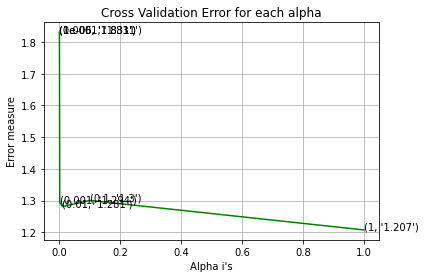

For values of best alpha =  1 The train log loss is: 0.7447930711302593
For values of best alpha =  1 The cross-validation log loss is: 1.2072840160058305
For values of best alpha =  1 The test log loss is: 1.1875625062247086


In [120]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

# 6. Models' Summary
- It is worthwhile to note that all of these scores are obtained after only a basic level of **hyper-parameter tuning**.
- In order to improve upon these scores, **Hyper-parameter tuning** and **K-fold cross-validation** are 2 of the options one can start exploring with.
- In the table, 
    - `CB`: Class Balancing
    - `WCB`: Without Class Balancing
    - `OHE`: One-Hot Encoding
    - `RE`: Response Encoding
    - `TFIDF`: TF-IDF Encoding for Text
    - `TFIDF1000`: TF-IDF Encoding for Text with Top 1000 features
    - `UB`: Both Unigrams & Bigrams

In [123]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model", "Attributes", "Train Log-Loss", "CV Log-Loss", "Test Log-Loss"]
x.add_rows([
    ["Naive Bayes", "OHE + WCB", 0.873, 1.289, 1.284],
    ["KNN", "Response Encoding + WCB", 0.456, 1.084, 1.052],
    ["Logistic Regression", "OHE + CB", 0.535, 1.103, 1.062],
    ["Logistic Regression", "OHE + WCB", 0.541, 1.112, 1.082],
    ["Linear SVM", "OHE + WCB", 0.566, 1.155, 1.117],
    ["Random Forest", "OHE + WCB", 0.700, 1.179, 1.164],
    ["Random Forest", "RE + WCB", 0.077, 1.314, 1.286],
    ["Stacking Classifier", "OHE + CB/WCB", 0.510, 1.187, 1.152],
    ["Maximum Voting Classifier", "OHE + CB/WCB", 0.873, 1.220, 1.210],
    ["Naive Bayes", "OHE + TFIDF + WCB", 0.621, 1.176, 1.172],
    ["Logistic Regression", "OHE + TFIDF + CB", 0.377, 0.970, 0.934],
    ["Logistic Regression", "OHE + TFIDF + WCB", 0.364, 0.969, 0.934],
    ["Linear SVM", "OHE + TFIDF + CB", 0.322, 1.019, 0.977],
    ["Random Forest", "OHE + TFIDF + WCB", 1.299, 1.405, 1.385],
    ["Naive Bayes", "OHE + TFIDF1000 + WCB", 0.643, 1.203, 1.194],
    ["KNN", "OHE + TFIDF1000 + WCB", 0.851, 1.138, 1.078],
    ["Logistic Regression", "OHE + TFIDF1000 + CB", 0.421, 1.017, 0.982],
    ["Logistic Regression", "OHE + TFIDF1000 + WCB", 0.407, 1.020, 0.986],
    ["Linear SVM", "OHE + TFIDF1000 + CB", 0.340, 1.075, 1.033],
    ["Random Forest", "OHE + TFIDF1000 + WCB", 0.505, 1.091, 1.084],
    ["Logistic Regression", "OHE + UB + CB", 0.851, 1.157, 1.157],
    ["Logistic Regression", "OHE + UB + WCB", 0.824, 1.189, 1.189],
])

In [124]:
print(x)

+---------------------------+-------------------------+----------------+-------------+---------------+
|           Model           |        Attributes       | Train Log-Loss | CV Log-Loss | Test Log-Loss |
+---------------------------+-------------------------+----------------+-------------+---------------+
|        Naive Bayes        |        OHE + WCB        |     0.873      |    1.289    |     1.284     |
|            KNN            | Response Encoding + WCB |     0.456      |    1.084    |     1.052     |
|    Logistic Regression    |         OHE + CB        |     0.535      |    1.103    |     1.062     |
|    Logistic Regression    |        OHE + WCB        |     0.541      |    1.112    |     1.082     |
|         Linear SVM        |        OHE + WCB        |     0.566      |    1.155    |     1.117     |
|       Random Forest       |        OHE + WCB        |      0.7       |    1.179    |     1.164     |
|       Random Forest       |         RE + WCB        |     0.077      | 